
# Real-world data coding for neuroscientists (ReCoN)

### MSc in Translational Neuroscience,

### Department of Brain Sciences, Faculty of Medicine,

### Imperial College London

### Contributors: Anastasia Ilina, Cecilia Rodriguez, Marirena Bafaloukou, Katarzyna Marta Zoltowska, Rishideep Chatterjee, Sahar Rahbar, Cynthia Sandor

### Autumn 2025




---

## Tutorial 3 – Tabular data with pandas on Electronic Healthcare Records (EHR)

### **Part 2: Data visualisation. Data cleaning and preprocessing with pandas**


---



## Learning outcomes

**Overall aim**: develop skills for statistical analysis of longitudinal medical data.

**You will learn to:**
- Effectively visualise distributions, trends and relationships in the data.
- Identify outliers and duplicates in tabular data.
- Handle missing data.


---
## 📚 Supporting matetials

> An absolute goldmine for data analysis (statistics + machine learning): 
> - [📶📚 Data Analysis by Mike Nguyen](https://bookdown.org/mike/data_analysis/)

> A lot of useful information (tutorials & examples) can be found in the official documentation of the libraries we use:
> - [🐼 Pandas documentation](https://pandas.pydata.org/docs/user_guide/index.html)
> - [📊 Matplotlib documentation](https://matplotlib.org/stable/contents.html)
> - [📉 Seaborn documentation](https://seaborn.pydata.org/index.html)

> There are also some cheat sheets that are a great reference for pandas & matplotlib methods:
> - [🐼 Pandas Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
> - [📊 Matplotlib Cheat Sheet](https://matplotlib.org/cheatsheets/cheatsheets.pdf)

> There are also useful Matplotlib guides for all levels:
> - [📊 Matplotlib Beginner Handout](https://matplotlib.org/cheatsheets/handout-beginner.pdf)
> - [📊 Matplotlib Intermediate Handout](https://matplotlib.org/cheatsheets/handout-intermediate.pdf)
> - [📊 Matplotlib Tips & Tricks](https://matplotlib.org/cheatsheets/handout-tips.pdf)




#### **Use the code below to create a synthetic dataset**

In [134]:
# === RUN THIS CELL TO (RE)CREATE THE SYNTHETIC DATASET ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix




# Fixed: 'ethinicity' -> 'ethnicity'
expected_cols = {"LEDD","sex","years_since_dx","age","updrs_iii","patient_id","ethnicity","BMI"}

# Only (re)create if df isn't already present with expected columns
if not (isinstance(globals().get("df"), pd.DataFrame) and expected_cols.issubset(df.columns)):
    rng = np.random.default_rng(0)
    n = 5000

    # ---- Core table ----
    df = pd.DataFrame({
        "patient_id": [f"P{i:04d}" for i in range(n)],
        "sex": rng.choice(["Male","Female"], size=n, p=[0.55, 0.45]),
        "years_since_dx": rng.uniform(0, 12, size=n).round(2),
        "age": rng.normal(62, 8, size=n).round(1),
        "ethnicity": rng.choice(["White", "Black", "Asian", "Other", ""],
                                size=n, p=[0.70, 0.10, 0.10, 0.05, 0.05]),
        "BMI": rng.normal(27, 4, size=n).round(1),
    })

    # ---- LEDD: base + exponential noise (skewed) ----
    df["LEDD"] = (250 + 50*df["years_since_dx"] + rng.exponential(500, size=n)).clip(0).round(1)

    # ---- UPDRS III: realistic 0–132 with progression + heterogeneity ----
    # Patient-level random intercepts (baseline severity) and slopes (annual change)
    unique_ids = df["patient_id"].unique()
    intercepts = pd.Series(np.clip(rng.normal(20, 6, size=len(unique_ids)), 0, 60), index=unique_ids)
    slopes     = pd.Series(np.clip(rng.normal(2.2, 0.9, size=len(unique_ids)), 0, 5), index=unique_ids)

    alpha = df["patient_id"].map(intercepts).to_numpy()
    beta  = df["patient_id"].map(slopes).to_numpy()
    years = df["years_since_dx"].astype(float).to_numpy()
    eps   = rng.normal(0, 5, size=len(df))  # visit-level noise

    updrs = np.clip(alpha + beta*years + eps, 0, 132)
    df["updrs_iii"] = np.round(updrs, 1)

    # Inject a few impossible outliers (>132) for teaching Winsorisation/capping
    n_out = max(20, int(0.004 * len(df)))  # ~0.4% or at least 20 rows
    idx_out = rng.choice(df.index, size=n_out, replace=False)
    df.loc[idx_out, "updrs_iii"] = np.round(rng.uniform(140, 220, size=n_out), 1)

    # ---- Intentional data-entry errors (for cleaning exercises) ----
    # BMI: ×10 typos and negatives
    df.loc[rng.choice(df.index, size=5, replace=False), "BMI"] *= 10
    df.loc[rng.choice(df.index, size=5, replace=False), "BMI"] *= -1
    # Age: negatives and unrealistic high values
    df.loc[rng.choice(df.index, size=5, replace=False), "age"] *= -1
    df.loc[rng.choice(df.index, size=5, replace=False), "age"] += 108

    # ---- Duplicate visits for some patients (longitudinal flavor) ----
    ###reps = df.sample(200, replace=True, random_state=0).copy()
    ##reps["patient_id"] = reps["patient_id"].sample(frac=1.0, random_state=1).values
    #df = pd.concat([df, reps], ignore_index=True)

    # make LEDD and UPDRS higher on average for men 
    df.loc[df["sex"]=="Male", "LEDD"] *= rng.uniform(1.05, 1.15, size=(df["sex"]=="Male").sum())
    df.loc[df["sex"]=="Male", "updrs_iii"] *= rng.uniform(1.05, 1.15, size=(df["sex"]=="Male").sum())

    # ---- MCAR missingness on selected columns ----
    for col, p in [("LEDD", 0.05), ("updrs_iii", 0.10), ("sex", 0.01), ("age", 0.02), ("ethnicity", 0.05)]:
        df.loc[rng.choice(df.index, size=int(p*len(df)), replace=False), col] = np.nan

    # ---- MNAR: LEDD more likely missing when UPDRS is high ----
    high_updrs = df["updrs_iii"] > 45
    # Safeguard: drop NaNs before sampling indices
    high_idx = df.index[high_updrs.fillna(False)]
    if len(high_idx) > 0:
        df.loc[rng.choice(high_idx, size=int(0.3*len(high_idx)), replace=False), "LEDD"] = np.nan

    df.reset_index(drop=True, inplace=True)

    # ---- Summary printout ----
    print(f"Created synthetic dataset with {len(df)} rows")
    print(f"Injected UPDRS>132 outliers: {(df['updrs_iii'] > 132).sum()}")
    print("Missingness (%):")
    print((df[["LEDD","updrs_iii","sex","age","ethnicity","BMI"]].isna().mean()*100).round(1))


Created synthetic dataset with 5000 rows
Injected UPDRS>132 outliers: 17
Missingness (%):
LEDD         10.6
updrs_iii    10.0
sex           1.0
age           2.0
ethnicity     5.0
BMI           0.0
dtype: float64


In [135]:
# ===== Inject duplicates in three buckets =====
# Counts: adjust as you like
n_exact = 40          # exact row duplicates
n_key   = 160         # same patient_id & years_since_dx (not exact)
n_repeat= 300         # legit repeated visits (different years_since_dx)

df_list = [df]

# --- 1) Exact row duplicates: true copy-paste of entire rows ---
idx_exact = rng.choice(df.index, size=n_exact, replace=False)
exact_dups = df.loc[idx_exact].copy()
df_list.append(exact_dups)

# --- 2) Key duplicates: same patient_id & same years_since_dx but slight entry drift ---
# pick base rows
idx_key = rng.choice(df.index.difference(idx_exact), size=n_key, replace=False)
key_dups = df.loc[idx_key].copy()

# Introduce small, realistic data-entry drift to numeric fields (but keep ID + time the same)
def small_perturb(x, scale):
    return np.round(x + rng.normal(0, scale, size=len(x)), 1)

if "LEDD" in key_dups:
    key_dups["LEDD"] = small_perturb(key_dups["LEDD"], scale=15)     # ±15 mg
if "updrs_iii" in key_dups:
    key_dups["updrs_iii"] = np.clip(small_perturb(key_dups["updrs_iii"], scale=1.5), 0, 220)
if "BMI" in key_dups:
    key_dups["BMI"] = np.round(key_dups["BMI"] + rng.normal(0, 0.3, size=len(key_dups)), 1)

# keep patient_id and years_since_dx unchanged (this makes them key duplicates)
df_list.append(key_dups)

# --- 3) Legit repeats: same patient, NEW years_since_dx (and recomputed fields) ---
# choose patients to get an extra visit
rep_patients = rng.choice(df["patient_id"].unique(), size=n_repeat, replace=False)

# For each chosen patient, create a new visit at a later (or earlier) year_since_dx
reps = df[df["patient_id"].isin(rep_patients)].copy()

# Propose a new time that differs from the current one by ~0.5–2.0 years
delta = rng.uniform(0.5, 2.0, size=len(reps))
sign  = rng.choice([1, -1], size=len(reps), p=[0.8, 0.2])  # mostly later visits
new_years = np.clip(reps["years_since_dx"].astype(float).to_numpy() + sign*delta, 0, 12)
reps["years_since_dx"] = np.round(new_years, 2)

# Age moves with time (if you want): comment out if not desired
if "age" in reps:
    reps["age"] = np.round(reps["age"].astype(float) + sign*delta, 1)

# Recompute LEDD and UPDRS for the *new* visit using the same subject-specific intercept/slope
pid = reps["patient_id"]
alpha_rep = pid.map(intercepts).to_numpy()
beta_rep  = pid.map(slopes).to_numpy()
years_rep = reps["years_since_dx"].astype(float).to_numpy()

# fresh noise terms
eps_rep = rng.normal(0, 5, size=len(reps))
updrs_rep = np.clip(alpha_rep + beta_rep*years_rep + eps_rep, 0, 132)
reps["updrs_iii"] = np.round(updrs_rep, 1)

# recompute LEDD with new years_since_dx
led_noise = rng.exponential(500, size=len(reps))
reps["LEDD"] = (250 + 50*reps["years_since_dx"].astype(float) + led_noise).clip(0).round(1)

# Append legit repeats
df = pd.concat(df_list + [reps], ignore_index=True)

# ---- Quick bookkeeping prints ----
print("\nInjected duplicates summary:")
print(f"  Exact duplicates added:         {len(exact_dups)}")
print(f"  Key-duplicates added:           {len(key_dups)}")
print(f"  Legit repeat visits added:      {len(reps)}")

# (OPTIONAL) Sanity counts right now (pre-missingness/multipliers)
exact_count = df.duplicated(keep=False).sum()
key_count   = df.duplicated(subset=['patient_id','years_since_dx'], keep=False).sum()
print(f"  Current exact-dup rows (counted individually): {exact_count}")
print(f"  Current key-dup rows (same patient+time):      {key_count}")



Injected duplicates summary:
  Exact duplicates added:         40
  Key-duplicates added:           160
  Legit repeat visits added:      300
  Current exact-dup rows (counted individually): 80
  Current key-dup rows (same patient+time):      400


In [136]:
# delete the df if needed to recreate a fresh version (uncomment and run if needed)
#del df

### Let's examine the datasets that we have been provided with. 

We can use pandas .display() and .describe() functions to get a quick overview of the data.


In [137]:
# Show the data
display(df)

,patient_id,sex,years_since_dx,age,ethnicity,BMI,LEDD,updrs_iii
0,P0000,Female,10.62,66.6,White,30.1,818.300000,44.900000
1,P0001,NaN,8.29,52.5,White,27.6,911.936129,31.957703
2,P0002,Male,5.78,63.4,White,19.3,1242.933872,27.852806
3,P0003,Male,8.15,70.2,Black,22.9,1683.987581,34.412344
4,P0004,Female,10.03,53.4,White,20.6,788.200000,35.400000
...,...,...,...,...,...,...,...,...
5495,P4932,Male,4.84,64.3,Black,24.7,1245.600000,39.300000
5496,P4942,Female,4.14,57.1,White,27.7,1501.400000,38.500000
5497,P4945,Male,5.78,51.6,White,27.6,1314.600000,41.400000
5498,P4968,Male,2.92,79.4,White,28.1,631.800000,24.200000


In [138]:
# Number of participants
df["patient_id"].nunique()

5000

> As you can see, some of the patients have multiple visits 

In [139]:
# describe the data
df.describe()

,years_since_dx,age,BMI,LEDD,updrs_iii
count,5500.000000,5391.000000,5500.000000,4950.000000,4981.000000
mean,6.021167,62.133927,27.141745,1099.492073,35.269241
std,3.459429,9.468886,9.206402,571.483863,16.248238
min,0.000000,-73.600000,-30.900000,238.600000,0.000000
25%,3.027500,56.800000,24.300000,715.152853,25.387597
50%,6.045000,62.100000,27.000000,959.100000,33.900000
75%,9.000000,67.700000,29.600000,1347.033845,43.350714
max,12.000000,181.900000,355.000000,6265.363225,237.617425


## ✏️ Now let's do some visualisations! 

### 📊 Count bar chart — frequency of a categorical variable

**When to use**: Show how often each category occurs (e.g., `sex`, `ethnicity`).
**Tips**: Sort bars by frequency; show an “Unknown” bucket for `NaN`/empty.

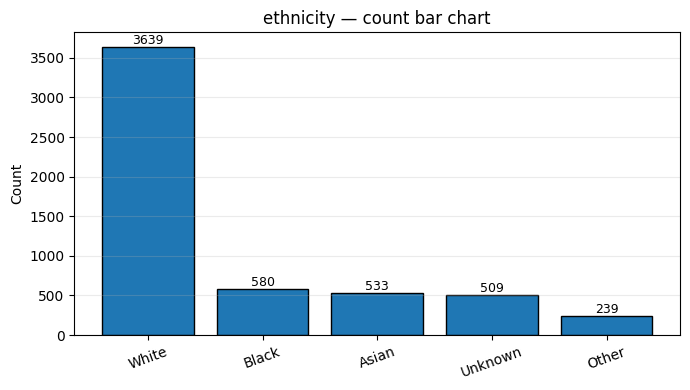

In [140]:

# Choose a column
col = "ethnicity"  # try "sex" as well

# Clean categories: map NaN/"" to "Unknown"
cats = df[col].replace("", np.nan).fillna("Unknown")

# Counts sorted descending
counts = cats.value_counts(dropna=False)

# Plot
plt.figure(figsize=(7,4))
bars = plt.bar(counts.index.astype(str), counts.values, edgecolor="black")
plt.title(f"{col} — count bar chart")
plt.ylabel("Count")
plt.xticks(rotation=20)

# Annotate bars with counts
for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y, f"{int(y)}", ha="center", va="bottom", fontsize=9)

plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

You can also use seaborn library to create count plots. Here's how you can do it:



/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_7502/1927832715.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filled, x=col, order=df_filled[col].value_counts().index, palette="pastel", edgecolor="black")


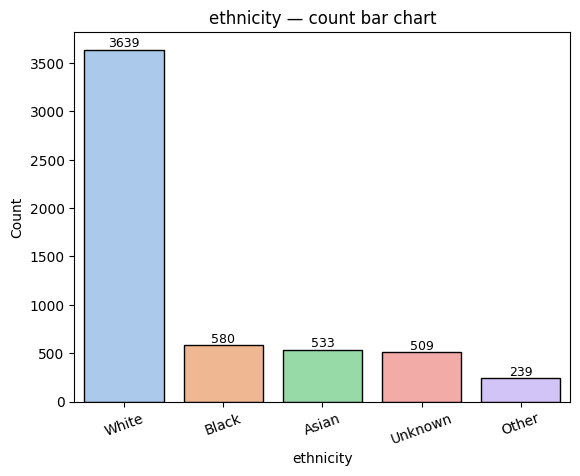

In [141]:
import seaborn as sns
df_filled = df.copy()
df_filled[col] = df_filled[col].replace("", np.nan).fillna("Unknown")
sns.countplot(data=df_filled, x=col, order=df_filled[col].value_counts().index, palette="pastel", edgecolor="black")
plt.title(f"{col} — count bar chart")
plt.ylabel("Count")
plt.xticks(rotation=20)

# Annotate bars with counts
counts = df_filled[col].value_counts()
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}',
                       (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom', fontsize=9)
plt.show()




### 📈 Proportion (percentage) bar chart

**When to use**: Emphasise **share** rather than raw counts (adds up to 100%).
**Tips**: Label bars with `%`; keep ordering consistent with the count plot.

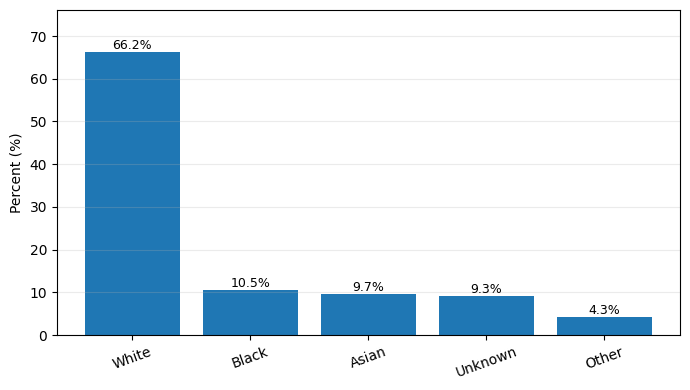

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

col = "ethnicity"
cats = df[col].replace("", np.nan).fillna("Unknown")
prop = (cats.value_counts(dropna=False, normalize=True)
            .sort_values(ascending=False))

plt.figure(figsize=(7,4))
bars = plt.bar(prop.index.astype(str), (100*prop.values))
plt.ylabel("Percent (%)")
plt.xticks(rotation=20)
plt.ylim(0, max(100*prop.values)*1.15)

for b, p in zip(bars, prop.values):
    y = 100*p
    plt.text(b.get_x() + b.get_width()/2, y, f"{y:.1f}%", ha="center", va="bottom", fontsize=9)

plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_7502/623984270.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filled, x=col, order=df_filled[col].value_counts().index, palette="pastel", edgecolor="black", stat = "percent")


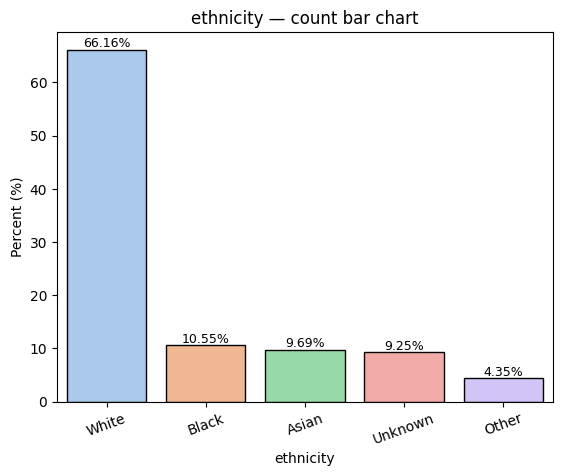

In [143]:
import seaborn as sns
df_filled = df.copy()
df_filled[col] = df_filled[col].replace("", np.nan).fillna("Unknown")
sns.countplot(data=df_filled, x=col, order=df_filled[col].value_counts().index, palette="pastel", edgecolor="black", stat = "percent")
plt.title(f"{col} — count bar chart")
plt.ylabel("Percent (%)")
plt.xticks(rotation=20)

# Annotate bars with counts
counts = df_filled[col].value_counts()
for p in plt.gca().patches:
    height = p.get_height() 
    percent_height = height / 100
    plt.gca().annotate(f'{percent_height:.2%}',
                       (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom', fontsize=9)
plt.show()


We can also modify continious variables to categorical ones (e.g. BMI groups) and plot their distributions as countplots


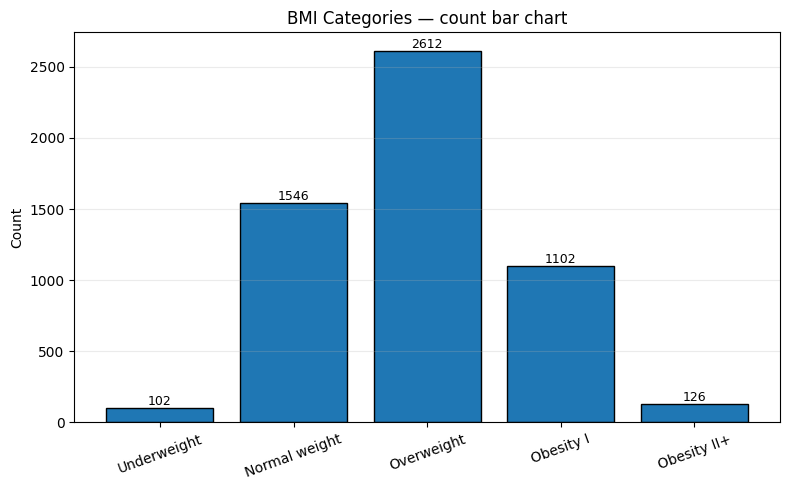

In [144]:
# Divide the BMI into categories
bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
labels = ["Underweight", "Normal weight", "Overweight", "Obesity I", "Obesity II+"]
df_filled["BMI_category"] = pd.cut(df_filled["BMI"], bins=bins, labels=labels, right=True)
# Plot the BMI categories with annotations
plt.figure(figsize=(8,5))
counts = df_filled["BMI_category"].value_counts().reindex(labels)
bars = plt.bar(counts.index.astype(str), counts.values, edgecolor="black")
plt.title("BMI Categories — count bar chart")
plt.ylabel("Count")
plt.xticks(rotation=20)
# Annotate bars with counts
for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y, f"{int(y)}", ha="center", va="bottom", fontsize=9)
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### 🧩 Grouped (clustered) bar chart — two categorical variables

**When to use**: Compare categories of `A` across levels of `B` (e.g., `ethnicity` by `sex`).
**Tips**: Use a fixed width per group and offset bars; keep a legend.

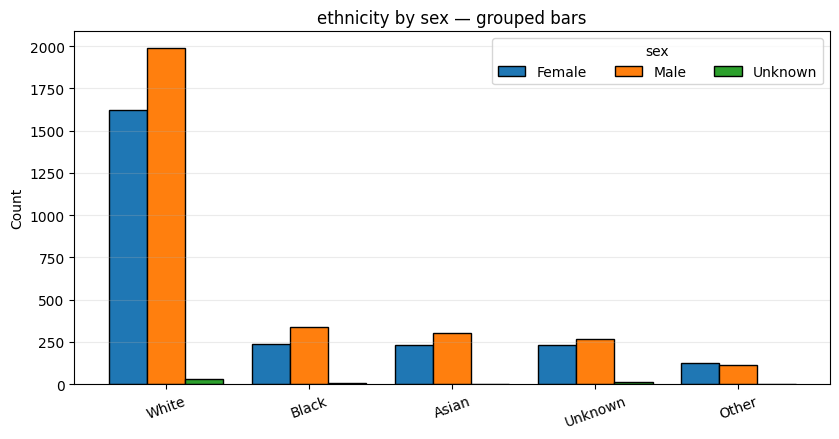

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cat_a = "ethnicity"   # x-axis groups
cat_b = "sex"         # bars within each group

A = df[cat_a].replace("", np.nan).fillna("Unknown")
B = df[cat_b].replace("", np.nan).fillna("Unknown")

# 1) Build the crosstab ONCE
ct = pd.crosstab(A, B)

# 2) Get row totals and sort those totals descending
row_order = ct.sum(axis=1).sort_values(ascending=False).index

# 3) Reindex rows by that order (no sorting by column labels needed)
ct = ct.reindex(row_order)

# 4) Plot grouped bars
groups = ct.index.astype(str)
levels = ct.columns.astype(str)
n_levels = len(levels)
x = np.arange(len(groups))
width = 0.8 / max(n_levels, 1)

plt.figure(figsize=(8.5,4.5))
for i, lev in enumerate(levels):
    offsets = x - 0.4 + i*width + width/2
    plt.bar(offsets, ct[lev].values, width=width, label=str(lev), edgecolor="black")

plt.xticks(x, groups, rotation=20)
plt.ylabel("Count")
plt.title(f"{cat_a} by {cat_b} — grouped bars")
plt.legend(title=cat_b, ncol=min(3, n_levels))
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


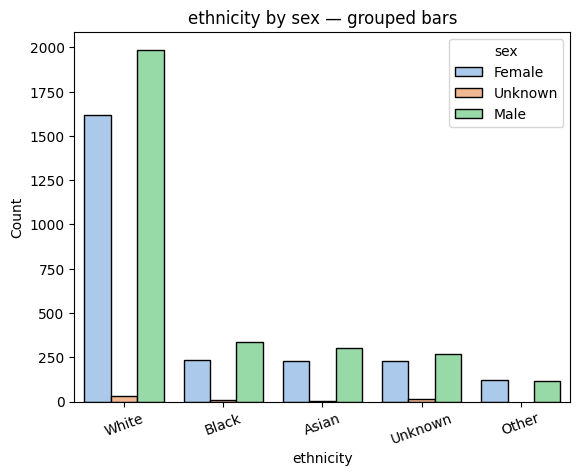

In [146]:
# Do the same in seaborn

df_filled["sex"]= df_filled["sex"].replace("", np.nan).fillna("Unknown")
sns.countplot(data=df_filled, x="ethnicity", hue="sex", order=df_filled["ethnicity"].value_counts().index, palette="pastel", edgecolor="black")
plt.title(f"{cat_a} by {cat_b} — grouped bars")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.show()




### 🧱 Stacked bar chart — composition within each group

**When to use**: Show totals with internal composition (counts).

**Tips**: Great when totals matter (height) *and* composition matters (segments).


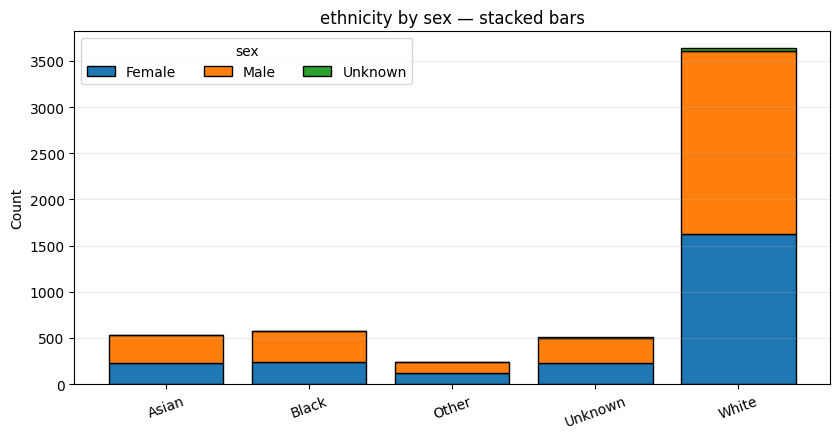

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cat_a = "ethnicity"   # x-axis
cat_b = "sex"         # stack segments

A = df[cat_a].replace("", np.nan).fillna("Unknown")
B = df[cat_b].replace("", np.nan).fillna("Unknown")
ct = pd.crosstab(A, B)

groups = ct.index.astype(str)
levels = ct.columns.astype(str)
x = np.arange(len(groups))

plt.figure(figsize=(8.5,4.5))
bottom = np.zeros(len(groups))
for lev in levels:
    vals = ct[lev].values
    plt.bar(groups, vals, bottom=bottom, label=str(lev), edgecolor="black")
    bottom += vals

plt.ylabel("Count")
plt.title(f"{cat_a} by {cat_b} — stacked bars")
plt.xticks(rotation=20)
plt.legend(title=cat_b, ncol=min(3, len(levels)))
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

### 💯 100% stacked bar chart — composition only (normalised)

**When to use**: Compare **composition shares** across groups; total height fixed to 100%.
**Tips**: Add percentage labels if segments are large enough.

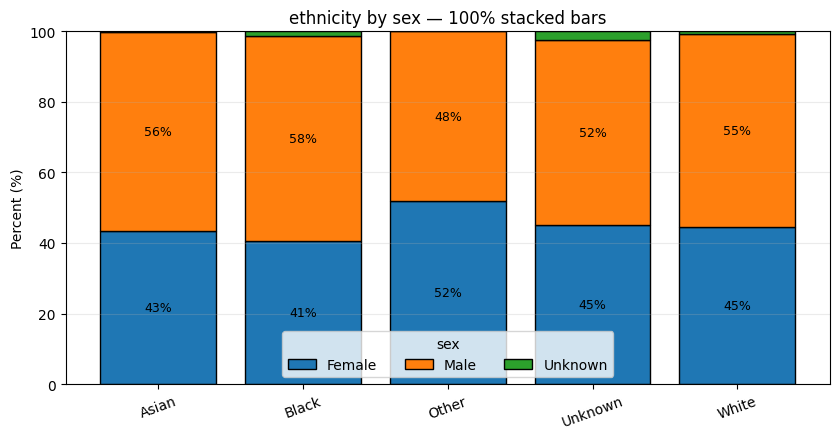

In [148]:

cat_a = "ethnicity"
cat_b = "sex"

A = df[cat_a].replace("", np.nan).fillna("Unknown")
B = df[cat_b].replace("", np.nan).fillna("Unknown")
ct = pd.crosstab(A, B)

# Row-normalise to proportions
prop = ct.div(ct.sum(axis=1), axis=0).fillna(0)

groups = prop.index.astype(str)
levels = prop.columns.astype(str)

plt.figure(figsize=(8.5,4.5))
bottom = np.zeros(len(groups))
for lev in levels:
    vals = (100 * prop[lev].values)
    plt.bar(groups, vals, bottom=bottom, label=str(lev), edgecolor="black")
    # Optional labeling on larger segments
    for i, v in enumerate(vals):
        if v >= 8:  # only label if segment >= 8%
            plt.text(i, bottom[i] + v/2, f"{v:.0f}%", ha="center", va="center", fontsize=9)
    bottom += vals

plt.ylabel("Percent (%)")
plt.title(f"{cat_a} by {cat_b} — 100% stacked bars")
plt.xticks(rotation=20)
plt.ylim(0, 100)
plt.legend(title=cat_b, ncol=min(3, len(levels)), loc="lower center")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()



#### Additional tips for categorical plots:

* Always decide whether to **show Unknowns**; hiding them can mislead percentages.
* For grouped/stacked charts, check category levels with very small counts—consider combining into **“Other (≤x%)”** for readability.
* If categories have a **natural order** (e.g., clinical stages), set it explicitly before plotting to avoid “alphabet soup”.

#### <span style="color:red"> 🍎 Now, your turn! </span>

<span style="color:red"> 

* In UPDRS III scale, cases with scores 0-32 are classified as 'Mild', 33-58 as 'Moderate', and above 59 as 'Severe'. Create a new categorical column 'UPDRS_Severity' in the dataframe based on these criteria. Then, plot a countplot showing the distribution of 'UPDRS_Severity' groups 

* Cluster the UPDRS III severity groups by sex using a grouped bar chart.

* Show the composition of UPDRS III severity groups within each ethnicity using a stacked bar chart.

</span>


In [ ]:
# Write your code here: 



### 📊 Histogram — distribution of a single variable
**When to use**: Explore the distribution of a numeric feature (e.g., age, LEDD)

**Tips**: Choose sensible bin counts; consider a log-scale if the tail is heavy


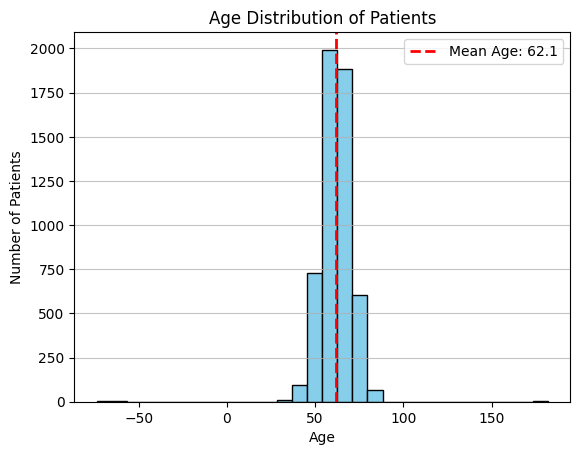

In [153]:
import matplotlib.pyplot as plt
# plot the histogram of age
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
# Add a vertical line for the mean age
plt.axvline(df['age'].mean(), color='red', linestyle='dashed', linewidth=2)
# add a legend for the mean line with its value
plt.legend([f'Mean Age: {df["age"].mean():.1f}'])
plt.grid(axis='y', alpha=0.75)
plt.show()

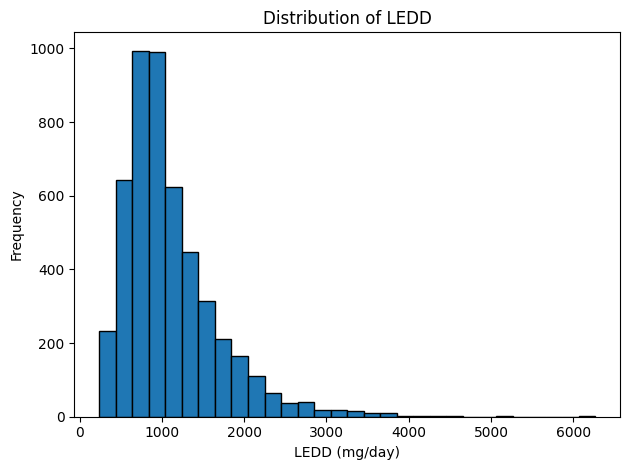

In [154]:
## Now let's plot the LEDD distribution

plt.figure()
plt.hist(df["LEDD"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of LEDD")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


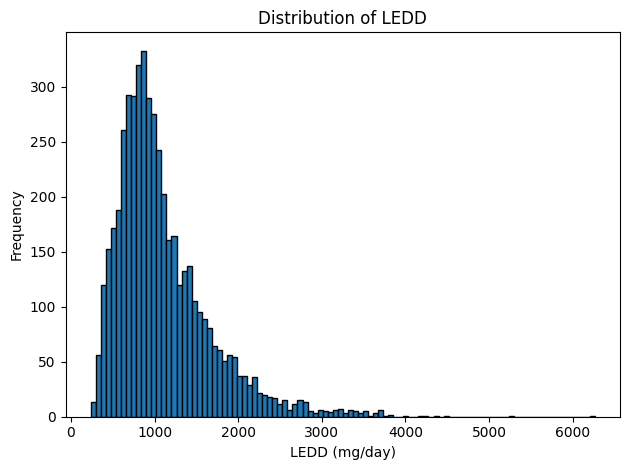

In [155]:
# Let's see what happens when we adjust the number of bins!
plt.figure()
plt.hist(df["LEDD"].dropna(), bins=100, edgecolor="black")
plt.title("Distribution of LEDD")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


You can also save the figures you create using plt.savefig() and specify the file format you want to save it in (e.g., .png, .jpg, .pdf) and the resolution (dpi).


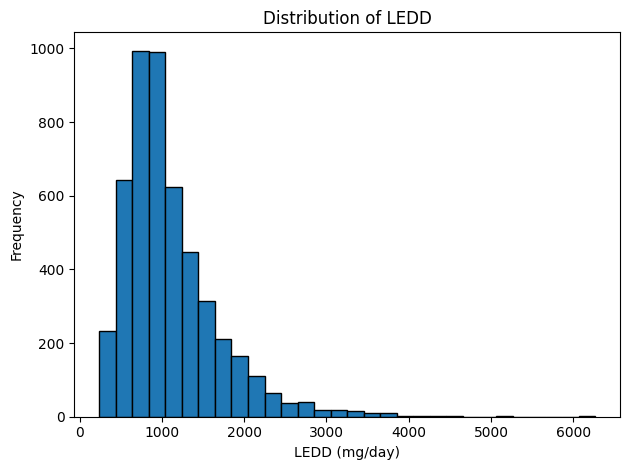

In [156]:
# Let's save a hisotgram of LEDD distribution in PNG format at 300 dpi
plt.figure()
plt.hist(df["LEDD"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of LEDD")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("ledd_distribution.png", dpi=300)
plt.show()




In our histogram, notice that **LEDD** has a **long right tail** — a few patients take **very high doses** of medication compared to the rest.
This kind of pattern is a good illustration of a **right-skewed** or **heavy-tailed** distribution that we talked about earlier. It is pretty common in medical data.

#### <span style="color:red"> 🍎 Now, your turn! </span>

<span style="color:red"> 

* What would be **the ordering** of the measures of central tendency (mean, median, mode) for this distribution if we plotted them? 

</span>

<span style="color:red"> 

* **Plot** the **mean, median**, and **mode** on the histogram above using vertical lines to check your answer! Add the values to the legend for the bonus points!
* Try different numbers of bins (e.g., 5, 10,  20, 50, 100) and see how it affects the histogram shape.

</span>


### <span style="color:red">If you've done things correcty, you should observe something like this: </span>

![](images/IMG_2882.jpg)


### <span style="color:red">Also, the value of the mode might be a bit surprising. Why is that? </span>

### 📈 Using Logarithmic Scales


![](images/IMG_2871.WEBP)

So, how can we better visualise such skewed data?
A **log transform** helps us *see* and *analyze* such data more clearly:

* It **compresses large values**, so the tall bars on the right no longer dominate the plot.
* It **stretches smaller values**, revealing detail in the lower range.
* As a result, the distribution often looks **more balanced and symmetric**, which can make statistical comparisons easier.


We can do this in two ways:

1. **Log-scale the y-axis** → keeps the data as-is but rescales the frequency axis.
2. **Plot the log of the variable** → transforms the data itself before plotting.

Here’s an example using a **log-scaled y-axis**:

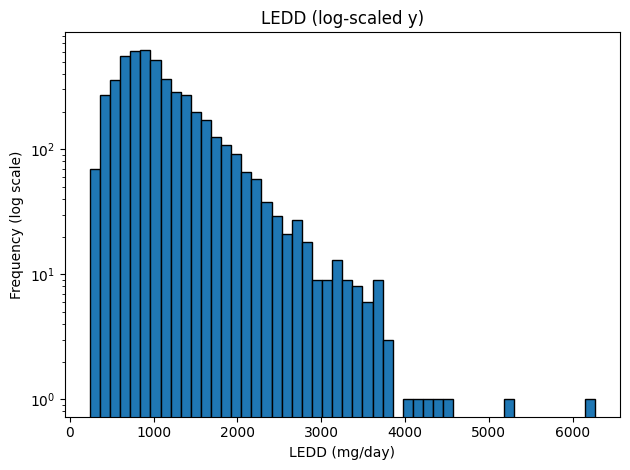

In [159]:

plt.figure()
plt.hist(df["LEDD"].dropna(), bins=50, edgecolor="black", log=True)
plt.title("LEDD (log-scaled y)")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency (log scale)")
plt.tight_layout(); plt.show()


And here's an example of plotting the **log of LEDD** directly:

Text(0.5, 0, 'log(LEDD + 1)')

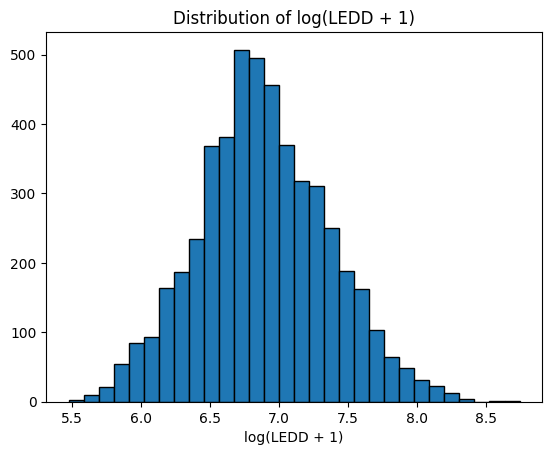

In [160]:
# log-transform the LEDD values
df["log_LEDD"] = np.log1p(df["LEDD"])  # log(LEDD + 1) to handle zero values
# Show the log_LEDD distribution
plt.figure()
plt.hist(df["log_LEDD"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of log(LEDD + 1)")
plt.xlabel("log(LEDD + 1)")         

### 📦 Boxplot — comparing group

**Concept**
Box plots are compact graphical summaries of the distribution of a quantitative variable. They were introduced by **John Tukey (1977)** as part of *Exploratory Data Analysis* to visualise central tendency, spread, and outliers without assuming any particular underlying distribution.

In the context of **Electronic Health Record (EHR)** or **clinical datasets**, variables such as medication dose, biomarker concentration, or symptom score often exhibit **skewed**, **non-normal**, and **heterogeneous** distributions.
Box plots provide an immediate overview of these properties across patient subgroups (for example, *LEDD by sex*, or *UPDRS III by disease stage*).


### 🧠 What a Box Plot Shows

| Component                | Statistical meaning                                                                                                                                 | Interpretation                                            |
| ------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------- |
| **Box (IQR)**            | Spans from 25th (Q1) to 75th percentile (Q3). The **height** represents the **interquartile range (IQR)**, containing the central 50 % of the data. | Range of "typical" medication doses or scores.                          |
| **Median line**          | The line inside the box marks the 50th percentile (Q2).                                                                                             | Typical patient’s value (robust to outliers).                           |
| **Whiskers**             | Extend to the most extreme data points within `Q1 − 1.5 × IQR` and `Q3 + 1.5 × IQR` (by default). Points beyond are flagged as *outliers*.          | Captures the expected variability across patients.                      |
| **Outliers**             | Observations outside the whiskers (often shown as dots).                                                                                            | Possible data entry errors, rare clinical cases, or extreme phenotypes. |
| **Notches** *(optional)* | Approximate a 95 % confidence interval around the median. Overlapping notches suggest non-significant differences.                                  | Useful when comparing treatment groups or sexes.                        |



🔎 **IQR rule**

 $ \text{IQR} = Q_3 - Q_1 $   
 $ \text{Outlier thresholds} = ( [Q_1 - 1.5·\text{IQR},, Q_3 + 1.5·\text{IQR}] ) $


#### 🧰 1. Box plots with **pandas**

`DataFrame.boxplot()` provides a quick summary using Matplotlib under the hood.

**Key parameters**

* `showfliers=False` – hide outlier markers (useful for dense data).
* `whis=(5,95)` – whiskers at specific percentiles instead of 1.5 × IQR.
* `notch=True` – display a confidence interval around the median.
* `vert=False` – horizontal orientation (useful for long category names).


<Figure size 640x480 with 0 Axes>

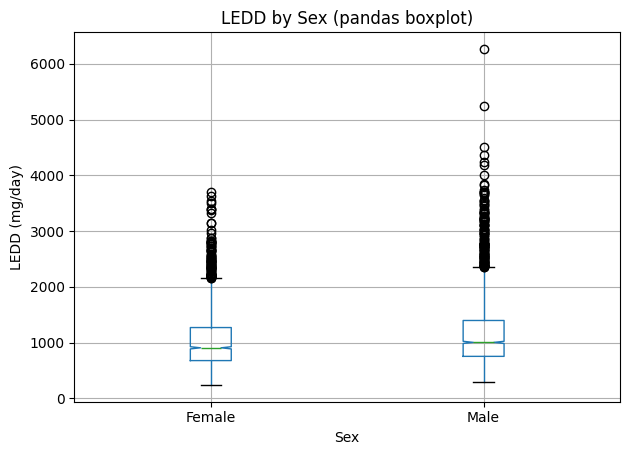

In [161]:
plt.figure()
df.boxplot(column="LEDD", by="sex", showfliers=True, notch=True, whis=1.5)
plt.title("LEDD by Sex (pandas boxplot)")
plt.suptitle("")  # remove auto super-title
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

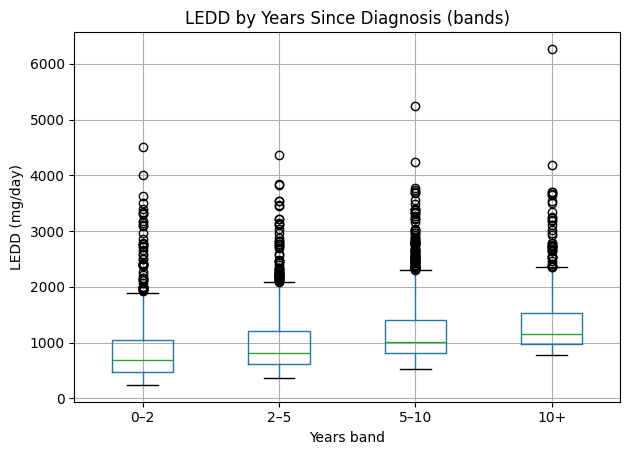

In [162]:
df["years_band"] = pd.cut(df["years_since_dx"], bins=[-0.01,2,5,10,20], labels=["0–2","2–5","5–10","10+"])
plt.figure()
df.boxplot(column="LEDD", by="years_band")
plt.title("LEDD by Years Since Diagnosis (bands)")
plt.suptitle("")
plt.xlabel("Years band")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()



### 🎨 2. Box plots with **matplotlib**

Matplotlib’s `ax.boxplot()` exposes all graphical components for customisation (colour, width, median line style, etc.).

You can:

* add `ax.set_yscale("log")` to visualise heavy-tailed medication data,
* overlay jittered points or mean lines for richer interpretation.







/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_7502/1326043903.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=groups, patch_artist=True, notch=True)


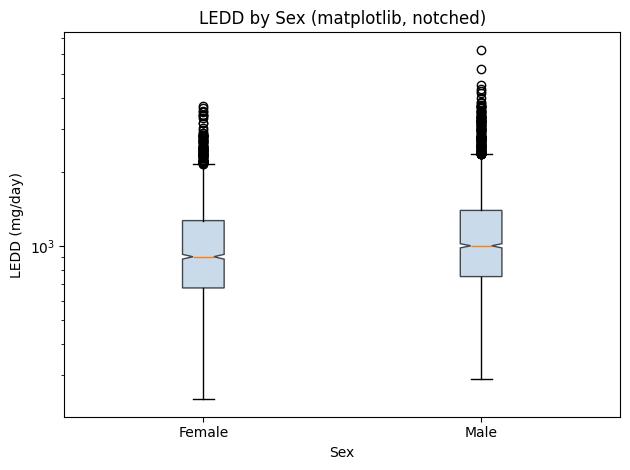

In [163]:
groups = ["Female", "Male"]
data = [df.loc[df["sex"].eq(g), "LEDD"].dropna() for g in groups]

fig, ax = plt.subplots()
bp = ax.boxplot(data, labels=groups, patch_artist=True, notch=True)
for box in bp["boxes"]:
    box.set(facecolor="#b3cde3", alpha=0.7)
ax.set_title("LEDD by Sex (matplotlib, notched)")
ax.set_xlabel("Sex")
ax.set_ylabel("LEDD (mg/day)")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

### 🧩 3. Box and Violin Plots with **seaborn**

Seaborn simplifies comparative distribution plots and handles grouping, colour palettes, and statistical overlays.

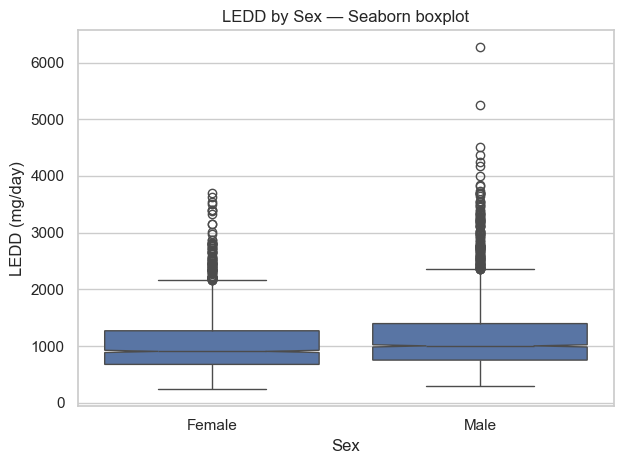

In [164]:


import seaborn as sns
sns.set_theme(style = "whitegrid")

plt.figure()
sns.boxplot(x="sex", y="LEDD", data=df, whis=1.5, showfliers=True, notch=True)
plt.title("LEDD by Sex — Seaborn boxplot")
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()


#### Violin plots — shape of the distribution

Violin plots combine a **kernel density estimate (KDE)** with the summary information of a box plot.
They reveal **asymmetry** and **multi-modality**, which are often hidden in box plots.


/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_7502/4116782057.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="sex", y="LEDD", data=df, inner="quartile", cut=0, scale="width")


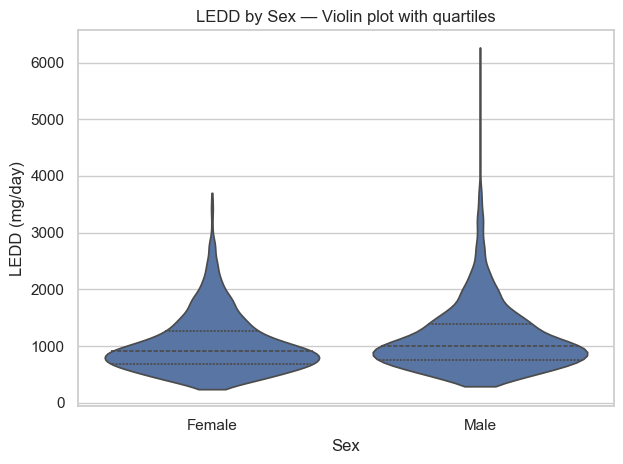

In [165]:


plt.figure()
sns.violinplot(x="sex", y="LEDD", data=df, inner="quartile", cut=0, scale="width")
plt.title("LEDD by Sex — Violin plot with quartiles")
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()



#### Combining multiple factors





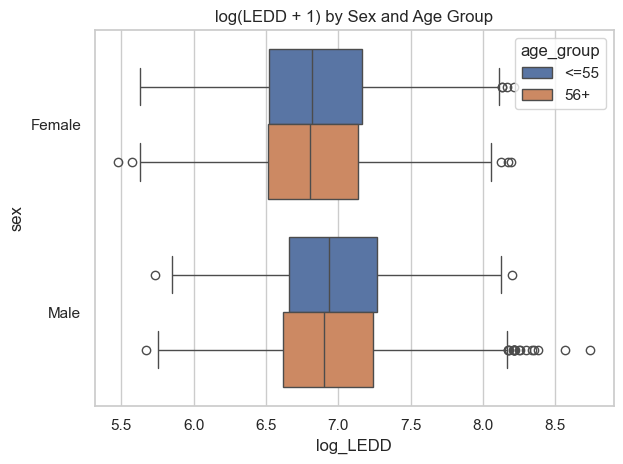

In [166]:
# create before/after 55 age groups (already in your code)
plt.figure()
df["age_group"] = pd.cut(df["age"], bins=[0,55,100], labels=["<=55","56+"])
sns.boxplot(x="log_LEDD", y="sex", hue="age_group", data=df)
plt.title("log(LEDD + 1) by Sex and Age Group")
plt.tight_layout()
plt.show()

#### Boxen plots (Letter-Value plots)

For large (n) (e.g., thousands of EHR records), **boxen plots** visualise many quantiles, providing a more detailed view of the tails.

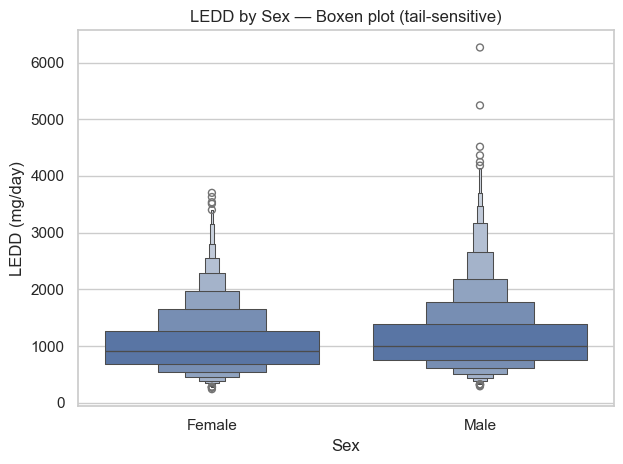

In [167]:
plt.figure()
sns.boxenplot(x="sex", y="LEDD", data=df)
plt.title("LEDD by Sex — Boxen plot (tail-sensitive)")
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()


### 🎯 Strip and Swarm Plots — Visualising Individual Observations

**Concept**

While box and violin plots summarise distributions, they can **hide the underlying data points** — important in biomedical datasets where:

* The number of observations per group may differ,
* Extreme values (e.g., very high LEDD) might reflect real clinical phenomena, and
* Visualising every data point can reveal *clusters, subgroups,* or *data entry errors*.

**Strip** and **swarm** plots show individual observations along a category axis:

* A **strip plot** adds random *jitter* to avoid overlap — good for small to moderate sample sizes.
* A **swarm plot** uses a smarter algorithm that avoids overlaps while preserving relative density — ideal for teaching and publication figures.

> Both are part of Seaborn’s *categorical plots* API and integrate seamlessly with box and violin plots.


### 🧩 Example 1 — Simple strip plot

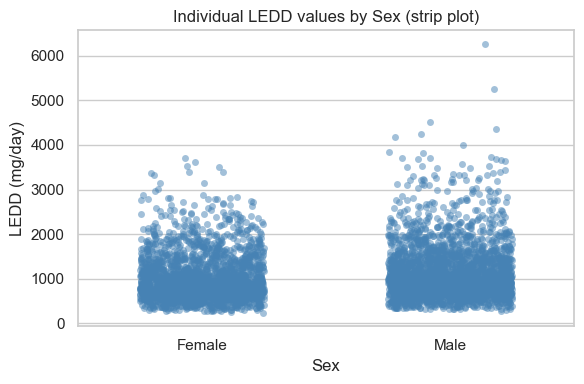

In [168]:
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.stripplot(
    x="sex", y="LEDD", data=df,
    jitter=0.25, alpha=0.5, color="steelblue"
)
plt.title("Individual LEDD values by Sex (strip plot)")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()

**Explanation**

* `jitter=0.25` adds small horizontal randomness to avoid overplotting.
* `alpha=0.5` makes overlapping points transparent.
* The overall height of each cloud approximates the data distribution.


### 🧩 Example 2 — Swarm plot (better spacing, density-aware)

/opt/anaconda3/envs/ledd_calculation/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/ledd_calculation/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/ledd_calculation/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/ledd_calculation/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 58.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


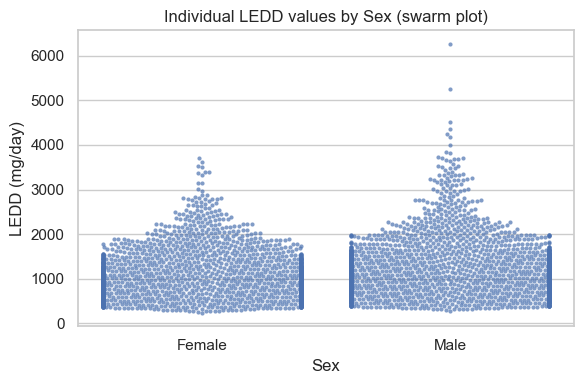

In [169]:
plt.figure(figsize=(6, 4))
sns.swarmplot(
    x="sex", y="LEDD", data=df,
    size=3, color="#4C72B0", alpha=0.7
)
plt.title("Individual LEDD values by Sex (swarm plot)")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()

**Explanation**

* Swarm plots arrange points to avoid overlap entirely, revealing *local density* and *outliers*.
* The vertical spread still reflects data values; horizontally, points are offset for visibility only.
* For large (n > 5000), sampling (`df.sample(1000)`) is recommended for performance.


### 🧩 Example 3 — Combining swarm and boxplot (best of both worlds)

This combination is commonly used in academic and clinical data visualisation: the **boxplot summarises** central tendency and IQR, while the **swarm overlay** reveals actual data points.

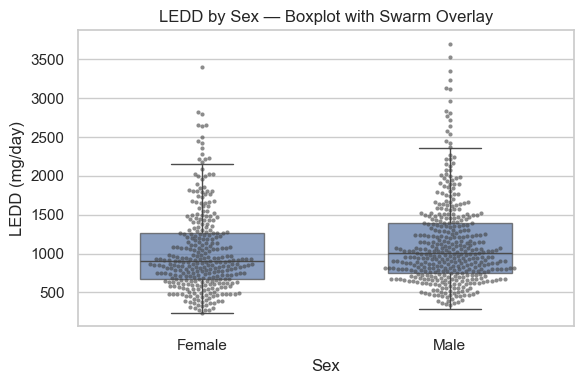

' \nThe random_state parameter here is used in functions that involve randomness (like shuffling or sampling); \nsetting it to a specific integer (e.g., random_state=42) ensures that the random process will produce the exact \nsame result every time you run the code. This is essential for reproducibility.\n'

In [170]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="sex", y="LEDD", data=df,
    whis=1.5, showfliers=False, width=0.5,
    boxprops=dict(alpha=0.7)
)
sns.swarmplot(
    x="sex", y="LEDD", data=df.sample(800, random_state=1),
    size=3, color="0.25", alpha=0.6
)
plt.title("LEDD by Sex — Boxplot with Swarm Overlay")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()


""" 
The random_state parameter here is used in functions that involve randomness (like shuffling or sampling); 
setting it to a specific integer (e.g., random_state=42) ensures that the random process will produce the exact 
same result every time you run the code. This is essential for reproducibility.
"""


**Interpretation in context**

* The box summarises median and IQR (typical dose range).
* The swarm points reveal **within-group variability**, **asymmetry**, and **potential outliers**.
* Particularly in clinical datasets, this helps distinguish **data artefacts** (isolated dots far outside the whiskers) from **genuine but rare cases**.


#### 🧮 Example 4 — Multigroup swarm (LEDD by sex × age group)

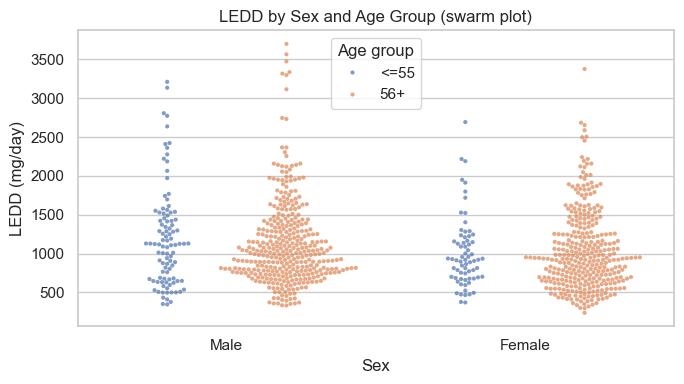

In [171]:
plt.figure(figsize=(7, 4))
sns.swarmplot(
    x="sex", y="LEDD", hue="age_group",
    data=df.sample(1000, random_state=0),
    dodge=True, size=3, alpha=0.7
)
plt.title("LEDD by Sex and Age Group (swarm plot)")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.legend(title="Age group")
plt.tight_layout(); plt.show()



### 🧠 Choosing & Interpreting Distribution Plots (clinical/EHR data)

Use the guide below to decide which plot to use for LEDD, UPDRS III, lab values, etc., and how to read them in a biomedical context.

#### Master comparison

| Plot / Scale          | When to use                                                 | Advantages                                         | Limitations / Caveats                                      |
| --------------------- | ----------------------------------------------------------- | -------------------------------------------------- | ---------------------------------------------------------- |
| **Box plot**          | Quick comparison of central tendency & spread across groups | Robust to outliers; compact; widely understood     | Minimal detail on distribution shape                       |
| **Violin plot**       | Assess distribution **shape** / multimodality               | Shows KDE density + quartiles (`inner="quartile"`) | Sensitive to bandwidth; individual points not shown        |
| **Boxen plot**        | Large samples; emphasise **tails** and extreme quantiles    | More quantiles than box; tail-sensitive            | Less familiar to audiences than box/violin                 |
| **Strip plot**        | Small/medium *n*; show raw points quickly                   | Simple; reveals outliers and clustering            | Overplotting at high density; relies on random jitter      |
| **Swarm plot**        | Medium *n*; teaching/publication figures with raw points    | Density-aware, non-overlapping, visually clear     | Slower and may fail to place all points for very large *n* |
| **Box + swarm**       | Balanced **summary + raw** overlay                          | Median/IQR + individual variability in one view    | Visual clutter if *n* very large (sample first)            |
| **Log-scaled y-axis** | Heavy-tailed variables (e.g., LEDD, biomarkers)             | Compresses extremes; reveals lower-range structure | Transforms perception of differences; explain to audience  |

---

### 🧩 Interpretation in a biomedical context

* **Wide IQRs** (box height) → heterogeneity in disease progression or treatment response.
* **Outliers** (beyond 1.5×IQR whiskers) → possible data entry errors, rare phenotypes, or clinically distinct subgroups; verify before removal.
* **Skew/asymmetry** → dosing ceilings/floors, clinician behaviour, or measurement limits; consider log scaling.
* **Group differences** (e.g., higher LEDD in males) → visual patterns should precede formal testing; report effect sizes and clinical relevance, not only *p*-values.


### 📚 References

* Tukey, J.W. (1977). *Exploratory Data Analysis.* Addison-Wesley.
* McGill, R., Tukey, J.W., & Larsen, W.A. (1978). *Variations of Box Plots.* **The American Statistician**.
* **Matplotlib** `pyplot.boxplot`: [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)
* **Seaborn** categorical plots tutorial: [https://seaborn.pydata.org/tutorial/categorical.html](https://seaborn.pydata.org/tutorial/categorical.html)
* **Seaborn** `violinplot`: [https://seaborn.pydata.org/generated/seaborn.violinplot.html](https://seaborn.pydata.org/generated/seaborn.violinplot.html)
* Waskom, M.L. (2021). *Seaborn: statistical data visualization.* **JOSS**, 6(60), 3021.


### 🔴 Scatter plot 
Scatter plots are used to visualise the relationship between two continuous variables. Each point represents an observation in the dataset, with its position determined by the values of the two variables being compared.


**Tips**:
* Use `alpha` (transparency) to reduce overplotting.
* Use `hue` for groups; optionally add `style` or `size`.
* Always drop NaNs for the variables you plot.



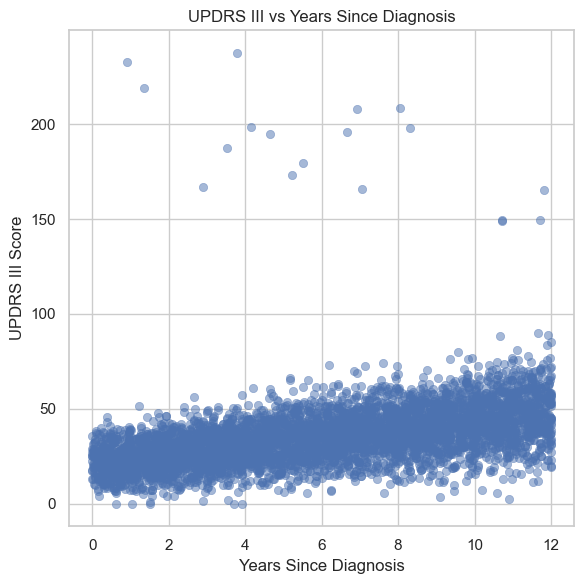

In [172]:
from matplotlib.pyplot import figure

cols = ["years_since_dx", "updrs_iii", 'sex']
df_plot= df.dropna(subset=cols)

figure(figsize=(6, 6))
sns.scatterplot(
    x="years_since_dx", y="updrs_iii",
    data=df_plot,
    alpha=0.5, edgecolor=None
)
plt.title("UPDRS III vs Years Since Diagnosis")
plt.xlabel("Years Since Diagnosis")
plt.ylabel("UPDRS III Score")
plt.tight_layout()
plt.show()




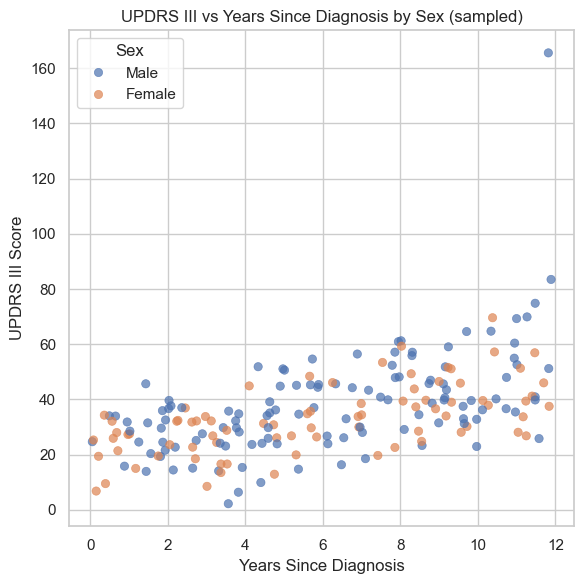

In [173]:

# Now let's look at just 200 random points to reduce overplotting and separate the groups by sex
sampled_df = df_plot.sample(n=200, random_state=42)
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="years_since_dx", y="updrs_iii",
    hue="sex",
    data=sampled_df,
    alpha=0.7, edgecolor=None
)
plt.title("UPDRS III vs Years Since Diagnosis by Sex (sampled)")
plt.xlabel("Years Since Diagnosis")
plt.ylabel("UPDRS III Score")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()  


---
## 🔎 Outliers & Data Entry Errors (theory → practice)

In clinical or EHR data, **outliers** are data points that look very different from the rest. **Outliers** and **data entry errors** are inevitable:

* Negative or implausible values (e.g., negative age, LEDD = 0.001 mg)
* Measurement or unit errors (e.g., mg ↔ g)
* Typing errors (extra zero → 5000 mg instead of 500)
* Genuine extreme patients (important to *keep* if plausible)

Before you impute missing data, always **check for and correct outliers** — otherwise, they can bias averages and distort imputation.

There’s no single “correct” way to detect outliers — instead, we use simple *rules of thumb* to **flag** unusual values for inspection.


### What to look for

* **Domain/range checks**: values outside plausible clinical ranges (e.g., rasagiline > 1 mg/day).
* **Impossible signs**: negative doses.
* **Unit mixups**: mg↔g (10×–1000× too big/small).
* **Distributional outliers**: IQR rule, z-scores.
* **Time-series anomalies**: sudden unrealistic jumps within a patient trajectory.

### What to do

* **Flag** → **Decide** (set to `NaN` & later impute, or clip to plausible range) → **Document**.
* It's considered a good practice to keep **a “raw” copy** and **a “cleaned” copy**. In this way, you can always refer back to the original data if needed, and run **sensitivity analyses** - for example, checking how results change with or without outliers.

###  Theory summary

| Concept           | Definition                                                 | Example / use in EHR                   |
| ----------------- | ---------------------------------------------------------- | -------------------------------------- |
| **Domain checks** | Apply known clinical ranges (e.g., LEDD > 0 mg, Age < 100) | Remove impossible values early         |
| **Z-score**       | Standardised value, flag cases where abs(z) > 3               | Detect statistically rare points       |
| **IQR rule**      | Define fences: Q1 − 1.5 × IQR, Q3 + 1.5 × IQR              | Robust to skewed data                  |
| **Winsorisation** | Cap extremes at chosen quantiles (e.g., 1 % / 99 %)        | Keeps extremes but limits their effect |

---

### Why this step comes **before** imputation

* Outliers can **pull the mean/variance**, biasing simple imputation and even MICE.
* Logging errors (negatives, mg↔g mixups, “0.001 mg”) should become `NaN` (or be clipped) **before** computing imputation statistics.


**Docs:** SciPy [`stats.zscore`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html), [`mstats.winsorize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html)

---
Now let's apply these principles to our Parkinson's dataset!

#### 1️⃣ Quick descriptive overview

In [174]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
years_since_dx,5500.0,6.021167,3.459429,0.000000,3.027500,6.045000,9.000000,12.000000
age,5391.0,62.133927,9.468886,-73.600000,56.800000,62.100000,67.700000,181.900000
BMI,5500.0,27.141745,9.206402,-30.900000,24.300000,27.000000,29.600000,355.000000
LEDD,4950.0,1099.492073,571.483863,238.600000,715.152853,959.100000,1347.033845,6265.363225
updrs_iii,4981.0,35.269241,16.248238,0.000000,25.387597,33.900000,43.350714,237.617425
log_LEDD,4950.0,6.888295,0.474591,5.478971,6.573894,6.867037,7.206402,8.742951


This gives you a feel for the **range** of each numeric column and how extreme some values might be.

#### 2️⃣ Visualise BMI distribution and spot potential outliers

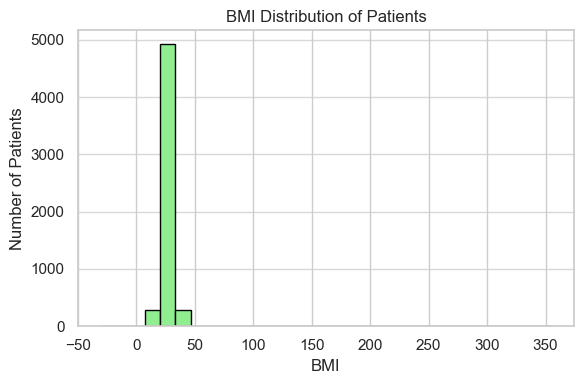

In [175]:
plt.figure(figsize=(6, 4))
plt.hist(df['BMI'].dropna(), bins=30, edgecolor='black', color='lightgreen')
plt.title('BMI Distribution of Patients')
plt.xlabel('BMI')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

> 💡 Normally, you would expect to see a roughly bell-shaped curve between 18–35. However, here, the scale of the graph looks off. Let's plot it with the log-scale to examine what happened.

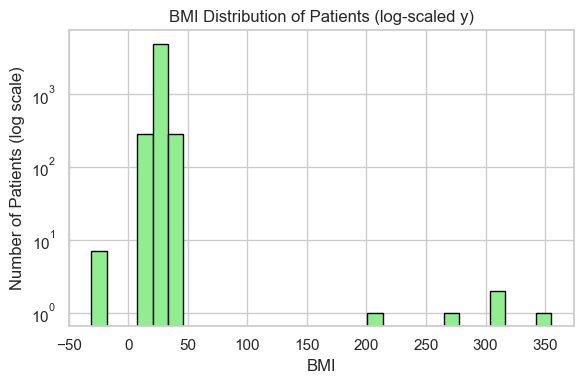

In [176]:
# Plot the histogram with log-scaled y-axis
plt.figure(figsize=(6, 4))
plt.hist(df['BMI'].dropna(), bins=30, edgecolor='black', color='lightgreen', log=True)
plt.title('BMI Distribution of Patients (log-scaled y)')
plt.xlabel('BMI')
plt.ylabel('Number of Patients (log scale)')    
plt.tight_layout(); plt.show()



> As you can see, there are some extreme outliers on the right side of the distribution, which are likely due to data entry errors. This is a common issue in real-world datasets, especially in clinical settings where data entry can be prone to mistakes. Identifying and addressing these outliers is crucial for ensuring the accuracy of subsequent analyses.

You can similarly see the extreme outliers when you're doing the **scatter plot** between BMI and any other variable of interest, for example, LEDD.

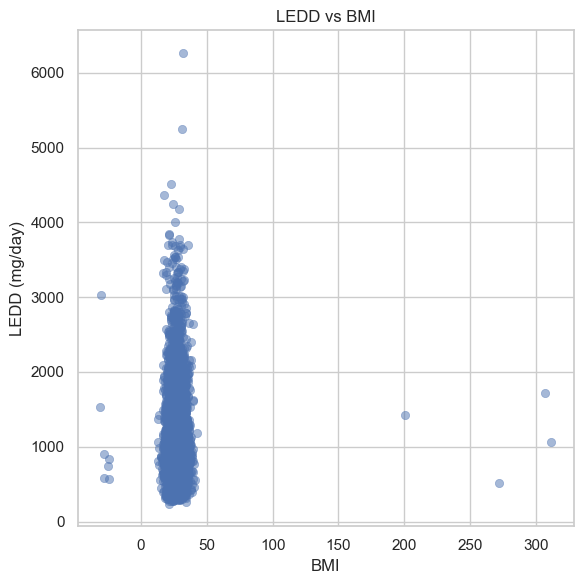

In [ ]:
# plote a scatter plot between BMI and LEDD
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="BMI", y="LEDD",
    data=df,
    alpha=0.5, edgecolor=None
)
plt.title("LEDD vs BMI")
plt.xlabel("BMI")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()

> As you can see, the outliers appear as isolated points far away from the main cluster of data. 

### 3️⃣ Detect BMI outliers statistically
We’ll use both the **IQR rule** (robust to skew) and the **Z-score** method (useful for normally distributed data).


#### 📊 The IQR rule (Interquartile Range)

The **IQR** looks at the “middle 50%” of your data.

Imagine lining up all BMI values from smallest to largest:

* The **median (Q2)** splits the data in half. It is shown in red on the boxplot.
* The **first quartile (Q1)** is the 25th percentile — where 25% of data are smaller. It is shown as boxplot borders on the boxplot.
* The **third quartile (Q3)** is the 75th percentile — where 75% of data are smaller. It is shown as boxplot borders on the boxplot.

The **IQR** = Q3 − Q1 → measures the *typical spread* of your data.

We then define **“fences”**:

$
\text{Lower fence} = Q1 - 1.5 \times \text{IQR}
$

$
\text{Upper fence} = Q3 + 1.5 \times \text{IQR}
$

The fences are shown as the ends of the whiskers on the boxplot (green lines) on the boxplot.

Anything outside these fences is *potentially* an outlier. They are visualised as gray dots on the boxplot.

✅ Good for: **non-normal data**, small datasets.
⚠️ Can miss subtle issues in highly skewed data.


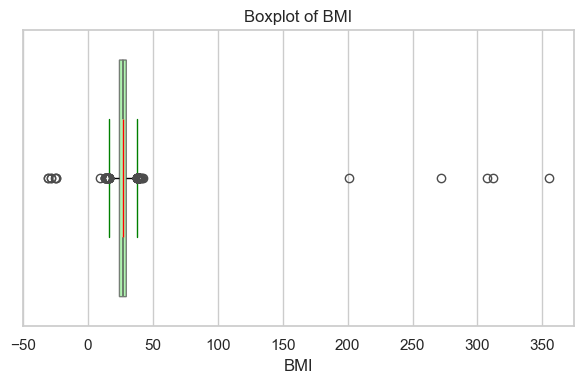

In [ ]:
# Create a boxplot of BMI data for IQR rule. Show the median, quartiles in different colors
plt.figure(figsize=(6, 4))
sns.boxplot(x="BMI", data=df, whis=1.5, showfliers=True, notch=True, medianprops=dict(color="red"), boxprops=dict(facecolor="lightgreen", alpha=0.7), whiskerprops=dict(color="black"), capprops=dict(color="green"))
plt.title("Boxplot of BMI")
plt.xlabel("BMI")
plt.tight_layout()
plt.show()

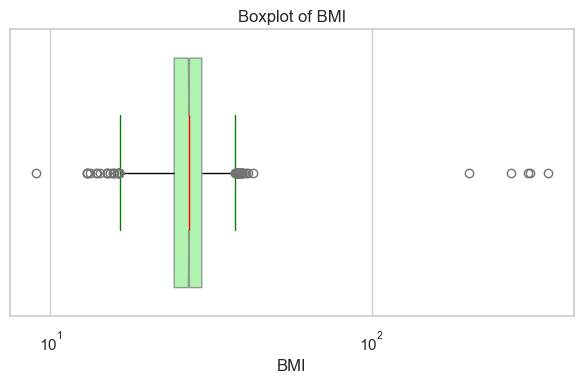

In [ ]:
# show the boxplot against a log-scaled x-axis
plt.figure(figsize=(6, 4))
sns.boxplot(x="BMI", data=df, whis=1.5, showfliers=True, notch=True, color='lightgreen', medianprops=dict(color="red"), boxprops=dict(facecolor="lightgreen", alpha=0.7), whiskerprops=dict(color="black"), capprops=dict(color="green"))
plt.title("Boxplot of BMI")
plt.xlabel("BMI")
plt.xscale("log")
plt.tight_layout()
plt.show()

Now let's calculate how many BMI outliers we have. Complete the code below to calculate and print the number of outliers according to the IQR rule.

In [180]:
from scipy import stats
## IQR method
q1, q3 = df["BMI"].quantile([0.25, 0.75])
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

print(f"IQR fences: {lower:.1f} – {upper:.1f}")

# complete the code to calculate and print the number of outliers according to the IQR rule
iqr_outliers = df[(df["BMI"] < lower) | (df["BMI"] > upper)]

print(f"IQR method: {len(iqr_outliers)} outliers (outside {lower:.1f}–{upper:.1f})")

IQR fences: 16.4 – 37.6
IQR method: 64 outliers (outside 16.4–37.6)





#### 🔢 The Z-score rule

The **Z-score** tells us *how many standard deviations a value is away from the mean.*

$
z = \frac{x - \text{mean}}{\text{standard deviation}}
$

If |z| > 3 (more than 3 SD away), it’s likely an outlier — less than 0.3% of normally distributed data fall that far from the mean.

✅ Good for: **normally distributed** variables (like BMI, height, blood pressure).
⚠️ Not ideal for **skewed** variables (like LEDD, which can grow exponentially).


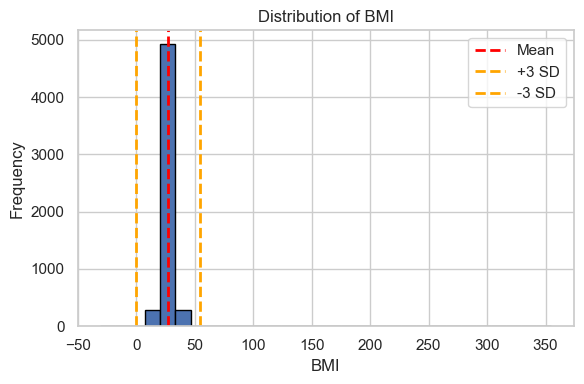

In [181]:
# Visualise the Z-score rule using histogram with standard deviation lines
plt.figure(figsize=(6, 4))
plt.hist(df["BMI"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of BMI")
plt.xlabel("BMI")
plt.ylabel("Frequency")
mean_bmi = df["BMI"].mean()
std_bmi = df["BMI"].std()
plt.axvline(mean_bmi, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_bmi + 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='+3 SD')
plt.axvline(mean_bmi - 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='-3 SD')
plt.legend()
plt.tight_layout()
plt.show()

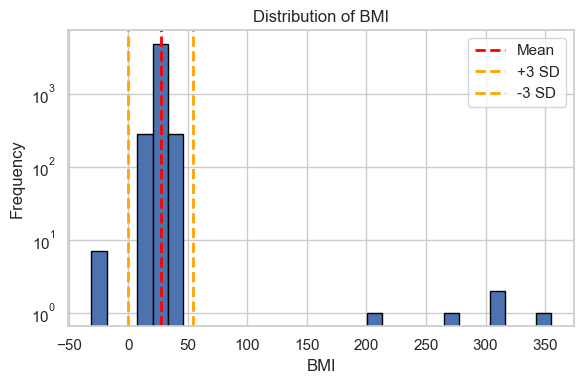

In [182]:
# Visualise the Z-score rule using histogram with standard deviation lines on log-scaled y-axis
plt.figure(figsize=(6, 4))
plt.hist(df["BMI"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of BMI")
plt.xlabel("BMI")
plt.ylabel("Frequency")
mean_bmi = df["BMI"].mean()
std_bmi = df["BMI"].std()
plt.axvline(mean_bmi, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_bmi + 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='+3 SD')
plt.axvline(mean_bmi - 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='-3 SD')
plt.legend()
plt.yscale("log")
plt.tight_layout(); plt.show()

Now let's calculate how many outliers we have according to the Z-score rule. Complete the code below to calculate and print the number of outliers.

In [183]:
# Z-score method
z_scores = stats.zscore(df["BMI"].dropna())

z_outliers = df.loc[df["BMI"].dropna().index[np.abs(z_scores) > 3]]
print(f"Z-score method: {len(z_outliers)} outliers (|z| > 3)")


Z-score method: 12 outliers (|z| > 3)


### 🧱 Robust outliers with MAD & modified Z-score
As we've already seen in the previous notebooke, **MAD**, or **Median Absolute Deviation**, is a robust measure of variability that is less sensitive to outliers than the standard deviation.

$$
\text{MAD}=\operatorname{median}\bigl(|x_i-\operatorname{median}(x)|\bigr)$$


Using MAD, we can calculate the **modified Z-score** (robust z), which would be more appropriate for skewed data:
$$
z_i^*=\frac{0.6745,(x_i-\operatorname{median}(x))}{\text{MAD}}
\quad\text{(equivalently } \frac{x_i-\operatorname{median}(x)}{1.4826\cdot \text{MAD}}\text{)}
$$


* The constants (0.6745) (or (1/1.4826)) make MAD comparable to the standard deviation for a Normal distribution.
* Rule of thumb: flag outliers where (|z^*|>3.5).
* **When to use**: skewed/heavy-tailed variables (e.g., LEDD, income, length-of-stay) or when a few extreme values inflate SD.

In [184]:


def mad_zscore(s: pd.Series, *, constant: float = 1.4826) -> pd.Series:
    """
    Robust z-score using median and MAD.
    Returns a Series aligned to s (NaNs preserved).
    """
    x = s.astype(float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if not np.isfinite(mad) or mad == 0:
        # All values equal or too few non-nulls: return zeros (no outliers)
        return pd.Series(np.zeros(len(x)), index=x.index, dtype=float)
    return (x - med) / (constant * mad)

# === Example on a skewed variable: LEDD ===
var = "LEDD"
z_mod = mad_zscore(df[var])
mad = np.nanmedian(np.abs(df[var] - np.nanmedian(df[var])))
median_val = np.nanmedian(df[var])
robust_sigma = 1.4826 * mad                      # robust SD-equivalent
thr = 3.5                                        # common MAD-z threshold
is_outlier = z_mod.abs() > thr

print(f"{var}: median={median_val:.1f}, MAD={mad:.1f}, robust σ≈{robust_sigma:.1f}")
print(f"Flagged outliers (|z*| > {thr}): {is_outlier.sum()} of {is_outlier.notna().sum()}")


LEDD: median=959.1, MAD=288.5, robust σ≈427.7
Flagged outliers (|z*| > 3.5): 153 of 5500


In [185]:

# Quick preview of extremes
display(df.loc[is_outlier, [var]].assign(mod_z=z_mod[is_outlier]).sort_values('mod_z'))

,LEDD,mod_z
3747,2456.625465,3.501099
771,2458.900000,3.506417
3510,2469.100000,3.530264
272,2469.403694,3.530974
4135,2471.900000,3.536810
...,...,...
3881,4245.780237,7.684005
919,4362.797990,7.957584
1865,4514.521929,8.312302
4915,5244.066938,10.017922


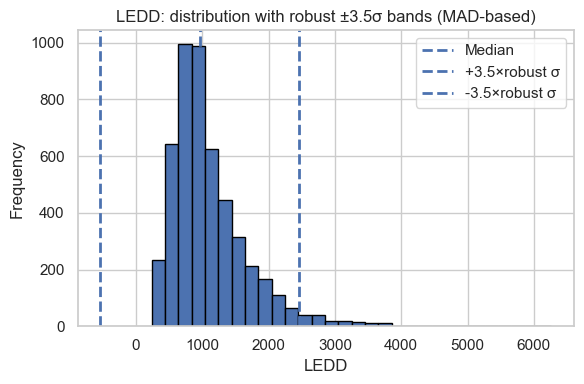

In [186]:

# ---- Visualise with robust bands ----
plt.figure(figsize=(6, 4))
vals = df[var].dropna()
plt.hist(vals, bins=30, edgecolor="black")
plt.title(f"{var}: distribution with robust ±{thr}σ bands (MAD-based)")
plt.xlabel(var); plt.ylabel("Frequency")

plt.axvline(median_val, linestyle="dashed", linewidth=2, label="Median")
plt.axvline(median_val + thr*robust_sigma, linestyle="dashed", linewidth=2, label=f"+{thr}×robust σ")
plt.axvline(median_val - thr*robust_sigma, linestyle="dashed", linewidth=2, label=f"-{thr}×robust σ")
plt.legend()
plt.tight_layout()
plt.show()



* If `MAD == 0` (e.g., many identical values), the modified z-score is undefined; the function above returns zeros (no outliers). You can instead return `np.nan` or fall back to classic z-scores if you prefer.
* For roughly Normal variables (e.g., BMI), classic Z-scores with (|z|>3) are fine; for skewed ones (e.g., **LEDD**), prefer **modified Z-scores with threshold ~3.5–4.0**.


### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>
1. Look at the distributions below, can you spot variables with potential outliers in the datasets? 
2. When you do, try to:
* Visualise the variable distributions with a histogram and a boxplot.
* Calculate how many outliers exist using both the IQR and Z-score methods.






In [ ]:
# Write your code here


## ⚕️ Handling Outliers in LEDD (exponential distribution)

Unlike BMI, **LEDD** values are **highly skewed** — most patients have modest doses, but a few take extremely large ones.
This happens naturally in Parkinson’s disease as treatment escalates over time.

**Challenge:** Traditional outlier rules (IQR or Z-score) treat the right-hand tail as “bad,” but here the tail is *expected*. And even with MAD-based modified Z-scores, we still can still flag many high but valid LEDD values as outliers. 

There exist several strategies to handle such data:

1. **Transform** the data (log-scale) so the tail compresses. If the data starts to look normal, we can then use standard outlier detection methods on the log-transformed data.
2. **Winsorise** (cap extremes) if we only want to summarise robustly.
3. **Use quantile-based trimming** (keep, say, 1st–99th percentile).

> Let's visualise LEDD once again and see the heavy right tail

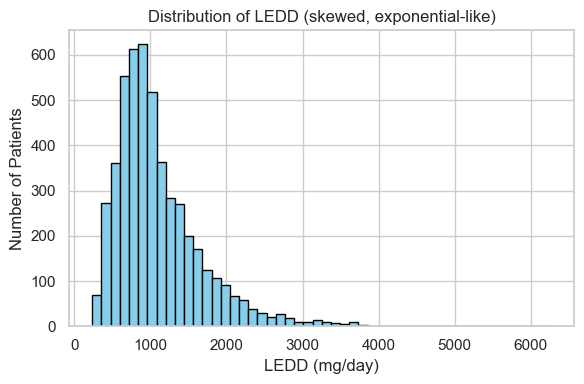

In [191]:
plt.figure(figsize=(6,4))
plt.hist(df["LEDD"].dropna(), bins=50, edgecolor="black", color="skyblue")
plt.title("Distribution of LEDD (skewed, exponential-like)")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

> Now, let's apply a log transformation for inspection! But now it's your turn to complete the code!

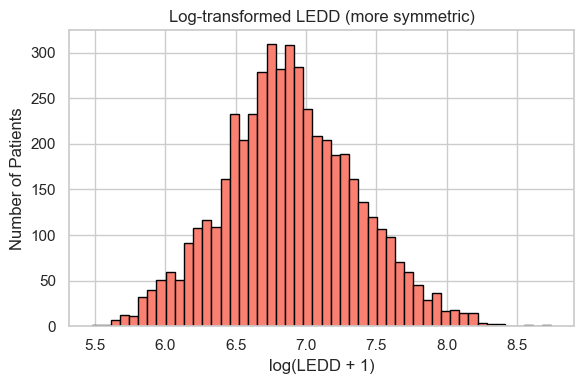

In [192]:
plt.figure(figsize=(6,4))
plt.hist(np.log1p(df["LEDD"].dropna()), bins=50, edgecolor="black", color="salmon")
plt.title("Log-transformed LEDD (more symmetric)")
plt.xlabel("log(LEDD + 1)")
plt.ylabel("Number of Patients")
plt.tight_layout() 
plt.show()

As you can see, the log-transformed LEDD distribution looks quite normal now! We can now apply the Z-score method to the log-transformed data to identify potential outliers.

To have **intepretable outlier thresholds** in the original LEDD scale, we can calculate the thresholds in the log scale and then exponentiate them back to the original scale. We’ll be doing outlier detection on a **multiplicative** scale (geometric world), which is usually what you want for dose-like variables.

#### ✅ How to do it (with back-transformed cut-offs)

* Transform: $y=\log(1+\text{LEDD})$ (use `log1p` to handle zeros).
* Compute classic Z on (y): $z=\frac{(y-\mu_y)}{\sigma_y}$
* Flag outliers with $|z|>k$ (e.g., (k=3)).
* Interpret in original units via **geometric mean** $g=\exp(\mu_y)-1$ and **geometric SD** $gSD=\exp(\sigma_y)$.

  * High cut-off (= $\exp(\mu_y+k\sigma_y)-1 = g \times (gSD)^k$)
  * Low cut-off (= $\exp(\mu_y-k\sigma_y)-1 = g \div (gSD)^k$)





In [193]:
var = "LEDD"
x = pd.to_numeric(df[var], errors="coerce")

# --- log-transform (handle zeros safely) ---
y = np.log1p(x)  # y = log(LEDD + 1)

mu, sigma = np.nanmean(y), np.nanstd(y, ddof=1)
z = (y - mu) / sigma
k = 3.0  # classic Z threshold

# Back-transform to original units for interpretable cut-offs
g_mean = np.exp(mu) - 1                    # geometric mean on original scale
g_sd   = np.exp(sigma)                     # geometric SD
hi_cut = np.exp(mu + k*sigma) - 1          # high outlier cutoff on original scale
lo_cut = np.exp(mu - k*sigma) - 1          # low outlier cutoff on original scale

is_out = (z.abs() > k)
print(f"{var}: geometric mean ≈ {g_mean:,.1f}, gSD ≈ {g_sd:,.3f}")
print(f"Outlier rule |z|>{k}:  x < {lo_cut:,.1f}  or  x > {hi_cut:,.1f}")
print(f"Flagged {is_out.sum()} of {z.notna().sum()} non-missing")

LEDD: geometric mean ≈ 979.7, gSD ≈ 1.607
Outlier rule |z|>3.0:  x < 235.2  or  x > 4,071.7
Flagged 6 of 4950 non-missing


In [194]:

# Optional: compare to robust MAD-z on original scale
def mad_zscore(s, constant=1.4826):
    med = np.nanmedian(s)
    mad = np.nanmedian(np.abs(s - med))
    if not np.isfinite(mad) or mad == 0:
        return pd.Series(np.zeros(len(s)), index=s.index, dtype=float)
    return (s - med) / (constant * mad)

z_mad = mad_zscore(x)
print(f"MAD-z (|z*|>3.5) flags { (z_mad.abs()>3.5).sum() } points")


MAD-z (|z*|>3.5) flags 153 points


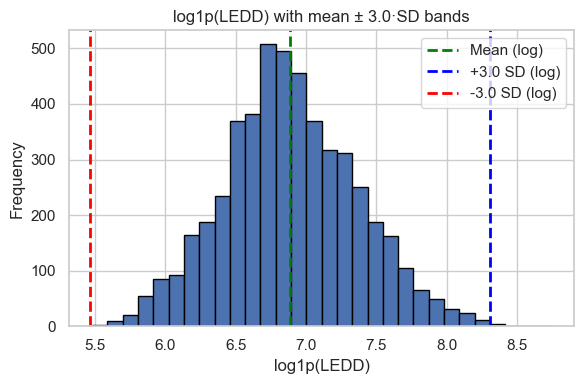

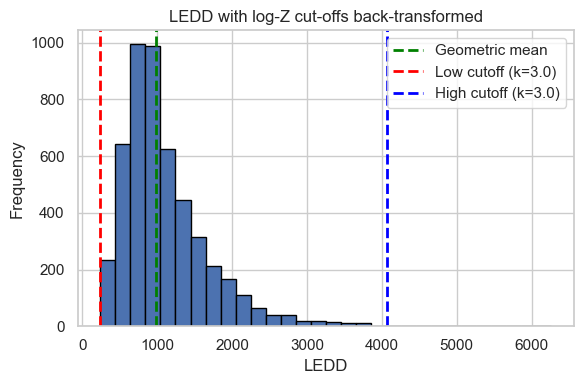

In [195]:

# --- Visualise on log scale with mean ± k*SD bands ---
plt.figure(figsize=(6,4))
plt.hist(y.dropna(), bins=30, edgecolor="black")
plt.title(f"log1p({var}) with mean ± {k}·SD bands")
plt.xlabel(f"log1p({var})"); plt.ylabel("Frequency")
plt.axvline(mu, linestyle="dashed", linewidth=2, label="Mean (log)", color="green")
plt.axvline(mu + k*sigma, linestyle="dashed", linewidth=2, label=f"+{k} SD (log)", color="blue")
plt.axvline(mu - k*sigma, linestyle="dashed", linewidth=2, label=f"-{k} SD (log)", color="red")
plt.legend()
plt.tight_layout()
plt.show()

# --- (Optional) Visualise original scale with back-transformed cutoffs ---
plt.figure(figsize=(6,4))
plt.hist(x.dropna(), bins=30, edgecolor="black")
plt.title(f"{var} with log-Z cut-offs back-transformed")
plt.xlabel(var); plt.ylabel("Frequency")
plt.axvline(g_mean, linestyle="dashed", linewidth=2, label="Geometric mean", color="green")
plt.axvline(lo_cut, linestyle="dashed", linewidth=2, label=f"Low cutoff (k={k})", color="red")
plt.axvline(hi_cut, linestyle="dashed", linewidth=2, label=f"High cutoff (k={k})", color="blue")
plt.legend()
plt.tight_layout()
plt.show()


### When to prefer which?

* If log(LEDD+1) looks ~Normal (check a histogram/QQ-plot), **classic Z on log scale** is great and has a clear multiplicative interpretation.
* If even log-LEDD is still heavy-tailed or you have many structural zeros/mixture distributions, **MAD-based z on the original scale** (or a **Yeo–Johnson** transform) is safer.

#### Detecting LEDD outliers using **percentile trimming**
When data are naturally skewed, it’s safer to flag only the *most extreme* few percent rather than using z-scores.

In [196]:
low, high = df["LEDD"].quantile([0.01, 0.99])
mask_trim = (df["LEDD"] < low) | (df["LEDD"] > high)

print(f"1st–99th percentile range: {low:.1f} – {high:.1f}")
print("Extreme LEDD values flagged:", int(mask_trim.sum()))

1st–99th percentile range: 345.7 – 3181.7
Extreme LEDD values flagged: 100



## 🧮 Winsorise LEDD for robust plots

#### 📚 What is *Winsorisation*?

**Winsorisation** (pronounced *win-sor-ization*) is a method used to **limit the influence of extreme values (outliers)** *without removing any data points*.

Instead of deleting the most extreme observations, we **replace** them with values at a chosen percentile threshold.

#### 💡 Intuitive Example

Imagine you have a dataset of daily medication doses for 1000 patients.
Most values are between **200 and 1500 mg**, but one data entry error says **15,000 mg**.
That one error will:

* stretch your histogram,
* distort your mean and standard deviation, and
* make your plots harder to interpret.

With **Winsorisation**, you *keep that data point*,
but you **cap** it at a reasonable upper limit — say the **99th percentile (≈ 1500 mg)**.

So instead of deleting the record, you replace:

> `15,000 → 1500`

You do the same for the lowest tail if needed.

#### ⚖️ Formal definition

If we Winsorise at the **1% and 99% levels**, we:

* Replace all values **below** the 1st percentile with the value at the 1st percentile.
* Replace all values **above** the 99th percentile with the value at the 99th percentile.

Mathematically:

$$
x_i' =
\begin{cases}
x_{p01}, & \text{if }~x_i < x_{p01}, \\
x_i, & \text{if }~x_{p01} \le x_i \le x_{p99}, \\
x_{p99}, & \text{if }~x_i > x_{p99}.
\end{cases}
$$

Where $x_{p01}$ and $x_{p99}$ are the 1st and 99th percentile values.



---

#### 🧠 Why use it?

* **Keeps all data points** (no deletion)
* **Reduces distortion** from rare errors or extreme but unimportant values
* **Improves robustness** of means and regressions
* **Makes histograms clearer** by “squashing” tails

⚠️ **However**:

* Winsorisation changes the actual data values, so it should only be used for **descriptive analysis or visualisation**, *not for inferential modelling* where true values matter.






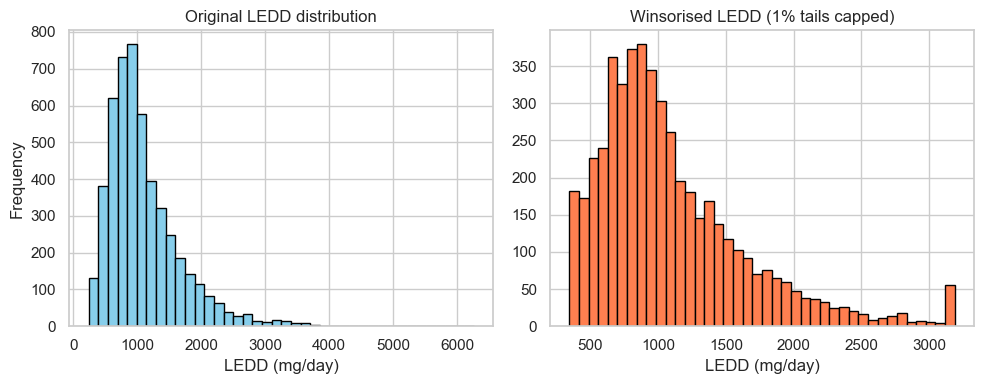

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Example: skewed LEDD values (as in your dataset)
x = df["LEDD"].dropna()

# Winsorise at 1% and 99%
x_winsor = winsorize(x, limits=[0.01, 0.01])

# Visualise the difference
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(x, bins=40, edgecolor="black", color="skyblue")
plt.title("Original LEDD distribution")
plt.xlabel("LEDD (mg/day)"); plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(x_winsor, bins=40, edgecolor="black", color="coral")
plt.title("Winsorised LEDD (1% tails capped)")
plt.xlabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()

### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

UPDRS III is a clinical rating scale for Parkinson's disease motor symptoms. It typically ranges from 0 to 132, with higher scores indicating more severe symptoms. However, in real-world datasets, you might encounter outliers due to data entry errors. Firstly, try to see how many datapoints lie outside of the 0 to 132 range

In [ ]:
# Write your code here 

### To clean this, we can either use robust z-scoring, capping or winsorisation.

Capping would involve converting any extreme values to the value of the closest boundary - setting any values below 0 to 0, and any values above 132 to 132.

P.S. use your pandas cheatsheet to find a one-liner method to cap values within a range:
[Pandas Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

In [ ]:
# First implement the MAD-based robust z-score cleaning

In [ ]:
# Now, Implement your capping method here (turn values outside 0-132 to nearest boundary)



Winsorising, on the other hand is done on percentiles (e.g., 1% and 99%, or 0.5% and 99.5%). Experiment with different percentile levels to see how they affect the distribution to try to find the one that aligns best with clinical expectations.

In [ ]:
# Write your code here

### Now let's compare the effect of MAD z-score vs capping vs winsorisation on the UPDRS III distribution. 

Visualise your best winsorised percentile alongside the capped and original distributions below


In [ ]:
# Write your code here:

#### <span style="color:red">Please answer below: which method (capping or winsorisation) do you think is better for cleaning UPDRS III, and why?



### ✅ Summary

| Aspect         | Winsorisation                                                        |
| -------------- | -------------------------------------------------------------------- |
| **Goal**       | Reduce the impact of extreme outliers without deleting data          |
| **How**        | Replace extreme values with percentile thresholds (e.g., 1st & 99th) |
| **Use when**   | You want robust summaries or clean visualisations                    |
| **Avoid when** | You need to preserve every raw data value for inference or auditing  |






### ✅ Key Points for Handling Outliers

* **Always inspect** data distributions visually first.
* Use **IQR or Z-score** rules to flag unusual values.
* Apply **domain logic** — e.g., BMI < 10 or > 60 → impossible, set to `NaN`.
* For analysis where you can’t remove extremes, use **Winsorisation**.
* Only after cleaning, proceed to **imputation**.





---

## ⚠️ Handling Outliers with Clinical Insight

When working with real-world clinical datasets, **outlier detection and handling is not just a technical step — it’s also an interpretive one**. Outliers may reflect genuine clinical phenomena rather than data errors, and removing them without careful consideration can erase valuable information.

For example, a patient with an **unusually high LEDD** might be on a complex or experimental treatment regimen, while a **very low UPDRS III score** could represent early-stage Parkinson’s disease or even a measurement artifact. In some analyses, these extreme cases are exactly the ones you want to understand — for instance, when studying treatment response variability or disease progression.

Before deciding to exclude an observation:

* **Visualize outliers in context** (e.g., with boxplots, scatterplots, or z-score histograms).
* **Differentiate data errors from true extremes.** A negative age or implausible score may justify correction or removal, but a genuine high value should be retained and possibly flagged for sensitivity analysis.
* **Document every decision** — which rules were used, which data points were flagged, and why. This ensures transparency and reproducibility.

If you need to keep extreme values in your analysis, consider using **robust statistical methods** that are less sensitive to outliers, such as:

* Median-based measures (e.g., the median and MAD instead of mean and SD)
* Rank-based nonparametric tests (will cover in the next notebook)
* Robust or quantile regression (will cover in future sessions)

Ultimately, **outlier handling requires a balance between statistical rigor and clinical judgment**. Outliers should trigger curiosity, not automatic deletion. When in doubt, visualize, document, and consult clinical experts — this ensures your data cleaning process respects both the underlying biology and the integrity of your analyses.

---




# 🧹 Duplicates and how to deal with them

In real datasets, “duplicates” can mean different things:

1. **Exact row duplicates**

   * Every column matches another row 1:1 (true copy-paste/merge artifact).
   * ✅ Safe to drop.

2. **Key duplicates** (same *entity + time/visit* appears more than once)

   * E.g., the same `patient_id` at the same `years_since_dx`.
   * Might be **legit** (two forms for the same visit) or **accidental** (double entry).
   * 🔎 Inspect first; if you must collapse, prefer a **deterministic rule** (e.g., keep the first, or aggregate with mean/median).

3. **Legit repeats** (longitudinal)

   * Same `patient_id` across *different* `years_since_dx`.
   * ✅ Keep—these are your repeated measures.

Below, we (a) remove exact duplicates, (b) *flag* suspected key duplicates for review, and (c) (optionally) resolve them with a transparent rule.

In [202]:
# --- 1) Remove exact row duplicates (safe) ---
n_before = len(df)
df_no_exact_dups = df.drop_duplicates(keep="first").copy()
n_removed_exact = n_before - len(df_no_exact_dups)
print(f"Removed {n_removed_exact} exact duplicate rows.")

Removed 40 exact duplicate rows.


In [203]:

# --- 2) Flag potential "key duplicates" (same patient & same visit/time) ---
# Define a visit-level key. Here: patient + years_since_dx (adjust if your real data uses visit_date, visit_id, etc.)
visit_key = ["patient_id", "years_since_dx"]

dup_mask = df_no_exact_dups.duplicated(subset=visit_key, keep=False)
suspected_key_dups = df_no_exact_dups.loc[dup_mask].sort_values(visit_key)

print(f"Potential key duplicates (same {visit_key}) found: {suspected_key_dups.shape[0]} rows"
      f" across {suspected_key_dups.groupby(visit_key).ngroups} visit keys.")

Potential key duplicates (same ['patient_id', 'years_since_dx']) found: 320 rows across 160 visit keys.


In [204]:
# Peek at a few problematic keys
display(
    suspected_key_dups
      .groupby(visit_key, as_index=False)
      .size()
      .sort_values("size", ascending=False)
      .head(10)
)

,patient_id,years_since_dx,size
0,P0015,1.87,2
1,P0032,2.50,2
102,P3362,5.67,2
103,P3373,8.00,2
104,P3419,8.94,2
105,P3434,11.22,2
106,P3482,7.84,2
107,P3484,10.71,2
108,P3528,3.73,2
109,P3532,1.23,2


In [205]:
# Optional: inspect the first few full records for a specific key (uncomment & set a key you saw above)
suspected_key_dups.query("patient_id == 'P4071' and years_since_dx == 2.16").head()

,patient_id,sex,years_since_dx,age,ethnicity,BMI,LEDD,updrs_iii,log_LEDD,years_band,age_group
4071,P4071,Male,2.16,43.9,Black,28.6,1346.24809,NaN,7.205819,2–5,<=55
5171,P4071,Male,2.16,43.9,Black,28.2,1351.40000,NaN,7.209636,2–5,<=55


In [206]:
# --- 3) (Optional) Resolve key duplicates with a clear rule ---
# If you decide that duplicates within a visit_key are accidental, choose ONE policy and document it.
# Here are two common approaches. Pick ONE and keep it consistent.

# A) Keep the first occurrence (deterministic, preserves original values)
df_keep_first = (
    df_no_exact_dups
      .sort_values(visit_key)        # ensure deterministic order
      .drop_duplicates(subset=visit_key, keep="first")
      .copy()
)

In [207]:
# B) Aggregate numeric columns within the same key (robust when multiple entries disagree)
numeric_cols = df_no_exact_dups.select_dtypes("number").columns.tolist()
non_numeric = [c for c in df_no_exact_dups.columns if c not in numeric_cols]

df_agg = (
    df_no_exact_dups
      .groupby(visit_key, as_index=False)
      .agg({**{c: "first" for c in non_numeric if c not in visit_key},  # keep first label/categorical
            **{c: "median" for c in numeric_cols}})                      # median is robust to outliers
)



In [208]:
# --- 4) Pick the final cleaned version you want to use downstream ---
# If you opted to just remove exact duplicates: use df_no_exact_dups
# If you resolved key duplicates by policy A: use df_keep_first
# If you resolved key duplicates by policy B: use df_agg

df_clean = df_keep_first  # <- choose one: df_no_exact_dups / df_keep_first / df_agg
print(f"Final rows after chosen policy: {len(df_clean)}")


Final rows after chosen policy: 5300


In [209]:

# --- 5) Sanity checks ---
# a) No exact duplicates remain:
assert not df_clean.duplicated().any(), "Exact duplicates still present."
# b) If you intended to be unique by visit_key:
assert not df_clean.duplicated(subset=visit_key).any(), "Key duplicates remain under chosen policy."

# Optional: quick summary of repeat structure (legit longitudinal pattern)
repeat_counts = df_clean.groupby("patient_id").size().describe()
print("\nVisits per patient (after cleaning):")
print(repeat_counts)


Visits per patient (after cleaning):
count    5000.000000
mean        1.060000
std         0.237511
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
dtype: float64


Count here describes the number of unique patients, whereas the mean shows the average number of visits per patient.

In [210]:
# Let's show the patients with more than 1 visit on different dates (should be legit longitudinal repeats)
multi_visit = df_clean.groupby("patient_id").filter(lambda x: len(x) > 1)
print(f"\nPatients with multiple visits: {multi_visit['patient_id'].nunique()} patients, {len(multi_visit)} total visits")


Patients with multiple visits: 300 patients, 600 total visits






**Notes & tips**

* If your real data has a true `visit_id` or a `visit_date`, prefer that (or `patient_id + visit_date`) as the key.
* Always **log your choice** (e.g., “key duplicates collapsed by median per visit key”) so results are reproducible.
* If two entries within the same key strongly disagree (e.g., `age` or `sex` differ), **don’t auto-aggregate**—flag for manual review.
* <span style="color: orange;"> **EXACT DUPLICATES CAN STILL BE MEANINGFUL** - e.g., in medication logs the same drug with the same dose/quantity/duration could be prescribed on the same day, indicating *bulk prescriptions*. **You should always interpret duplicates in the context of the data source and domain knowledge** </span>




## 🧩 Missingness & Imputation 

Real-world **medical and EHR data** are almost never complete — sensors fail, tests aren’t ordered, or data entry is inconsistent.
Before analysis, we must understand **what’s missing** and **how to handle it**.

A great supplementary resource is this [comprehensive guide on missing data](https://bookdown.org/mike/data_analysis/imputation-missing-data.html) from [Nguyen, M. (2020). A Guide on Data Analysis](https://bookdown.org/mike/data_analysis/)

### 🧠 Types of Missingness

#### Missing Completely At Random (MCAR)

* **Idea:** The missingness is pure luck—unrelated to *anything* in your data (neither the missing value itself nor any other variables).
* **Example:** A lab machine randomly fails 5% of the time for all patients, regardless of their true lab values or characteristics.
* **Implication:** Analyses on just the complete cases are unbiased (you only lose power/precision). This is the *strongest* and least realistic assumption.

#### Missing At Random (MAR)

* **Idea:** Missingness relates to other *observed* data. Once you account for variables you *do* observe, missingness does not depend on the unseen value itself.
* **Example:** In a multi-clinic study, LDL cholesterol results are missing more often at Clinic B because their lab is overbooked on certain days. You *do* have the clinic ID and the day of the week recorded. Conditional on clinic and day, whether LDL is missing doesn’t depend on the person’s true LDL value. That’s MAR: missingness is explained by *observed* variables, not by the unobserved LDL itself.
* **Implication:** You can usually fix this with standard tools (e.g., **multiple imputation**) that include those observed predictors of missingness.

#### Missing Not At Random (MNAR)

* **Idea:** Even after using all the observed variables, the *unseen* value itself still affects whether it’s missing.
* **Example:** People with higher income are more likely to skip the income question, or not attend the survey altogether. Even after accounting for their age, education, and job type,  missingness still depends on the unreported income itself.
* **Implication:** You generally need **specialized models** or **sensitivity analyses**; standard imputation assuming MAR can be biased.


A quick way to remember:

* **MCAR:** missingness ~ unrelated to anything.
* **MAR:** missingness ~ related to *observed* things.
* **MNAR:** missingness ~ related to the *unobserved* value itself (even after using what you observe).


---

### 🧍‍♀️🩺 Item vs. Unit Nonresponse — how “missing” actually appears in your dataset

When data are “missing,” that can mean **two slightly different things** in practice:

| Type of missingness  | What it looks like in the dataset                                                                                  | Example                                                                                                       |
| -------------------- | ------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------- |
| **Item nonresponse** | You *see* a row for the patient or visit, but one or more fields are **NaN/blank**.                                | A patient attended clinic, but UPDRS wasn’t recorded that day.                                                |
| **Unit nonresponse** | There’s **no row at all** for that person or visit because it never happened (e.g., they skipped the appointment). | A patient with severe symptoms stops attending altogether, so their later visits don’t appear in the dataset. Or, patients with severe motor symptoms never enrolled in the study and thus never attended the clinic - they were never recorded in the dataset. |

Both item and unit nonresponse can occur under MCAR, MAR, or MNAR — the distinction is **where the gap appears**, not *why* it happens.
If missingness depends on the **unobserved value itself** (e.g., severe patients dropping out), that’s **MNAR**, even if the record never appears.

In most EHR or clinical trial data:

* MCAR usually shows up as random NaNs.
* MAR often shows predictable NaNs related to other variables (e.g., site, age, time).
* MNAR can cause entire visits or patients to vanish or not be recorded at all — not just NaNs in one field.

---

| Type                                    | Meaning                                                        | Example                                                                                                 |
| --------------------------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **MCAR** — Missing Completely At Random | The missingness has nothing to do with the data (pure chance). | A lab result is lost due to a computer crash.                                                           |
| **MAR** — Missing At Random             | Missingness relates to other *observed* data.                  | Older patients have more missing UPDRS scores.                                                          |
| **MNAR** — Missing Not At Random        | Missingness depends on the *unobserved* value itself.          | Patients with very severe UPDRS stop attending the clinic, so later visits are absent from the dataset OR patients with severe motor symptoms never enrolled in the study and thus never attended the clinic - they were never recorded in the dataset. |

---


### “Which case is mine?” (and what can you test)

#### What you *can* test

* **MCAR can be tested (somewhat).**

  * **Little’s MCAR test**: a global test that asks “do the observed patterns look like MCAR?” If it **fails**, you can rule out MCAR. If it **passes**, MCAR is *plausible* (not proven).

* **Simple diagnostics that often falsify MCAR and support MAR:**

  * Make a **missingness indicator** for each variable, e.g., `miss_weight = 1 if weight is missing else 0`.
  * Regress `miss_weight` on other observed variables (logistic regression) or do t-tests/chi-square tests
    > <span style="color:orange; font-weight:bold"> you will learn the theory behind those tests in later parts of this tutorial, for now, we will just provide you with the code snippets to run them. </span>
  * If `miss_weight` is **associated** with observed variables (e.g., age, BMI, site), then MCAR is unlikely; **MAR becomes plausible** if those variables are included in your model/imputation.

#### What you *cannot* test

* **You cannot empirically prove MAR vs MNAR from your data alone.**

  * MAR is an **assumption** you justify by showing that missingness relates to things you *do* observe (and that you include them in the model).
  * MNAR is typically a **substantive judgment** (e.g., “people with worse symptoms drop out precisely because of the symptom severity we didn’t observe”) plus **sensitivity analysis**.

#### Practical workflow to classify your case

1. **Plot and tabulate missingness** (heatmaps, patterns by variable/time/site).
2. **Create missingness indicators** and check associations with observed variables.

   * Strong associations → **MCAR unlikely**. If associations make real-world sense and you can include those predictors → **MAR plausible**.
3. **Think substantively**: is there a believable reason the *unseen* value itself drives nonresponse/dropout, even after controls? If yes → **MNAR plausible**.
4. **If in doubt**: proceed under MAR (with good predictors) **and** run **MNAR sensitivity analyses**.

---
### Term explanations 

* **Missingness indicator:** A 0/1 variable marking whether a value is missing. Used to study the missingness process.
* **Regression diagnostics:** Statistical tests (e.g., logistic regression) to see if missingness indicators relate to observed variables.
* **Multiple Imputation (MI):** Fill in missing values **multiple** times to create several complete datasets, analyze each, and **combine** results (Rubin’s rules). Captures uncertainty from missingness.

* **Sensitivity analysis:**  = a “what-if” stress test for your results. For the purpose of this module, this is too much to cover. However, it's still useful to understand what it does.It asks: “If our key assumption is a bit wrong, how much would our conclusion change?”
You don’t try to prove the truth, you vary your assumptions and see how stable your result is. For instance, you might run your analysis assuming MAR, then re-run it under various MNAR scenarios - imagine that we assume that people who skip UPDRS have scores 1 points higher than predicted under MAR. Then you can see if your main conclusion (e.g., treatment effect) still holds. 

> “Primary analyses assumed MAR. We conducted a sensitivity analysis using delta-adjusted MI, shifting imputed UPDRS for missed visits by +0.3 to +1.0 points. The treatment effect ranged from −2.1 (MAR) to −1.7 (Δ=+1.0), and remained statistically significant, suggesting conclusions are robust to moderate MNAR.”

Here's another worked example for income imputation:

Suppose you impute income under **MAR**. Then you re-run with **MNAR-style shifts** for nonresponders:

| Scenario (assumption about nonresponders) | Mean income estimate |
| ----------------------------------------- | -------------------- |
| MAR (no shift)                            | $51k                 |
| MNAR: +$5k higher than MAR predicts       | $53k                 |
| MNAR: +$10k higher                        | $55k                 |
| MNAR: +$20k higher                        | $59k                 |

Interpretation: If it’s plausible nonresponders earn $5–10k more, your mean rises notably—your results are **sensitive** to MNAR.

If you're interested in learning more about sensitivity analyses and other techniques for MNAR, consider exploring resources like:
* [Sensitivity Analysis from Flexible Imputation of the Missing Data by Stef van Buuren](https://stefvanbuuren.name/fimd/sec-sensitivity.html)
* [Missingness in Data Analysis by Mike Nguyen](https://bookdown.org/mike/data_analysis/imputation-missing-data.html)




#### 1️⃣ Check How Much Data Is Missing

Let’s start by seeing **where and how much** is missing.


In [211]:
# Check total missing values per column
df_clean.isna().sum()

patient_id          0
sex                51
years_since_dx      0
age               106
ethnicity         266
BMI                 0
LEDD              530
updrs_iii         500
log_LEDD          530
years_band          0
age_group         116
dtype: int64

You can also see this as **percentages**:

In [212]:

(df_clean.isna().mean() * 100).round(1)

patient_id         0.0
sex                1.0
years_since_dx     0.0
age                2.0
ethnicity          5.0
BMI                0.0
LEDD              10.0
updrs_iii          9.4
log_LEDD          10.0
years_band         0.0
age_group          2.2
dtype: float64

#### 🔍 Visualize Missingness

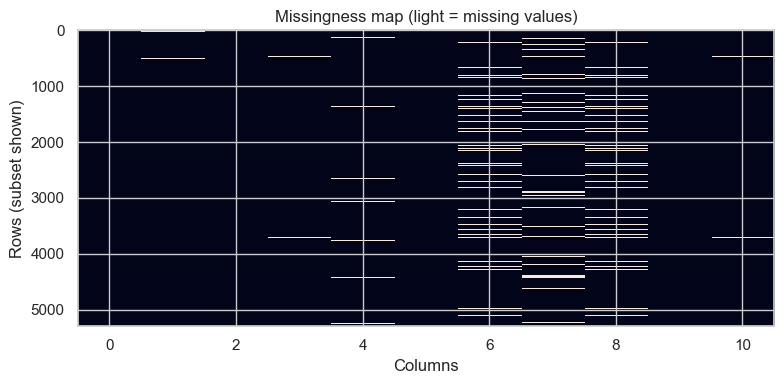

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.imshow(df_clean.isna(), aspect="auto", interpolation="none")
plt.title("Missingness map (light = missing values)")
plt.xlabel("Columns")
plt.ylabel("Rows (subset shown)")
plt.tight_layout()
plt.show()

This quick “heatmap” shows missing cells as lighter areas — typical in longitudinal EHRs where not every test is recorded at each visit.


## 🧭 A Primer on Associations

Before we can diagnose missingness, we need to understand what **association** means in statistics. 
> We will have a deeper dive into associations and other statistical tests in later notebook today, but for now, here’s a quick primer.

Statisticians say two variables are **associated** if knowing the value of one gives us some information about the other — in other words, their values are *not independent*.

* If there’s **no association**, the two variables vary independently — there’s no predictable pattern between them.
* If there **is an association**, there’s some systematic pattern: when one changes, the other tends to change too (positively or negatively).

### 🟢 Example: Visual intuition

In scatterplots:

![](images/associations_scatter_plot_examples.png)

* **No association** → the points are a random cloud.
* **Positive association** → as one increases, the other tends to increase.
* **Negative association** → as one increases, the other tends to decrease.
* **Non-linear association** → there’s a pattern, but it’s not a straight line (e.g., U-shaped).



## 🧮 Measuring Association

Different measures fit different variable types:

| Variable Types                                                         | Measure of Association                                       | What it tells you                                                        | Python one-liner                      |
| ---------------------------------------------------------------------- | ------------------------------------------------------------ | ------------------------------------------------------------------------ | ------------------------------------- |
| **Continuous ↔ Continuous**                                            | **Pearson** (linear) or **Spearman** (rank/monotonic)        | Do two numeric variables move together?                                  | `df.corr(method="spearman")`          |
| **Continuous ↔ Binary** (e.g., *missingness indicator* vs a lab value) | **Point-biserial correlation**                               | Strength/direction of association between a numeric value and a 0/1 flag | `pointbiserialr(x, y)`                |
| **Categorical ↔ Categorical**                                          | **Chi-squared test** (optionally **Cramér’s V** effect size) | Are category distributions independent?                                  | `chi2_contingency(pd.crosstab(a, b))` |
| **Ordinal ↔ Ordinal (or vs Continuous)**                               | **Spearman**                                                 | Association using ranks; robust to outliers                              | `df.corr(method="spearman")`          |




## 🧩 Why this matters for missing data

We can use **association tests** to learn *why* data might be missing:

* If the **missingness indicators** are *not associated* with any other variables → missingness might be **MCAR**.
* If the **missingness indicators** *are associated* with other observed variables → missingness is likely **MAR**.
---



## 🧪 Example: Exploring associations between missingness and observed variables
Here’s how we can explore this idea with code.

In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency

# -------------------------------------------
# 1) Build missingness indicators (0 = observed, 1 = missing)
# -------------------------------------------
missing_indicators = df_clean.isna().astype(int).add_suffix("_missing")
df_with_ind = pd.concat([df_clean, missing_indicators], axis=1)

# Identify column types
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
# exclude patient_id if present
if "patient_id" in cat_cols:
    cat_cols.remove("patient_id")
miss_cols = missing_indicators.columns.tolist()

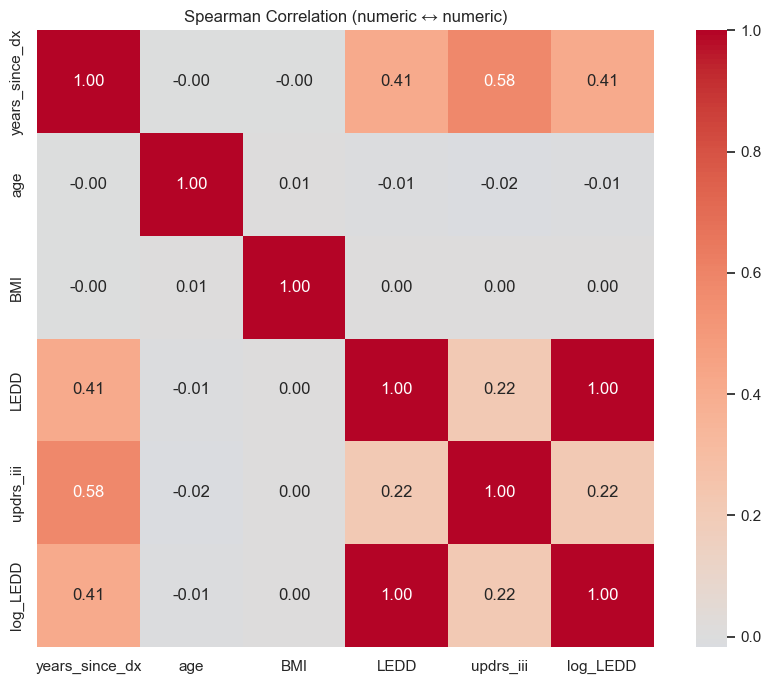

In [215]:

# -------------------------------------------
# 2) Spearman correlation among numeric variables (robust to skew/outliers)
# -------------------------------------------
spearman_corr = df_with_ind[num_cols].corr(method="spearman")

plt.figure(figsize=(9, 7))
sns.heatmap(spearman_corr, cmap="coolwarm", center=0, annot=True, fmt=".2f", square=True)
plt.title("Spearman Correlation (numeric ↔ numeric)")
plt.tight_layout()
plt.show()

So, from the correlation matrix we can see that years since diagnosis is positively associated with both LEDD and UPDRS III scores. And LEDD also shows a positive association with UPDRS III. 

However, this heatmap does not directly tell us about missingness because **all the missingness indicators are binary variables** (0 = observed, 1 = missing)

,missing_var,continuous_var,r_pb,p_value
20,LEDD_missing,updrs_iii,0.260152,4.288571e-75
17,LEDD_missing,years_since_dx,0.139330,2.180550e-24
18,LEDD_missing,age,-0.014730,2.885211e-01
19,LEDD_missing,BMI,0.011276,4.117893e-01
31,age_group_missing,age,-0.038470,5.556757e-03
35,age_group_missing,log_LEDD,0.023828,9.987308e-02
30,age_group_missing,years_since_dx,0.022059,1.083319e-01
33,age_group_missing,LEDD,0.021140,1.443413e-01
34,age_group_missing,updrs_iii,-0.007385,6.090042e-01
32,age_group_missing,BMI,-0.005419,6.932828e-01


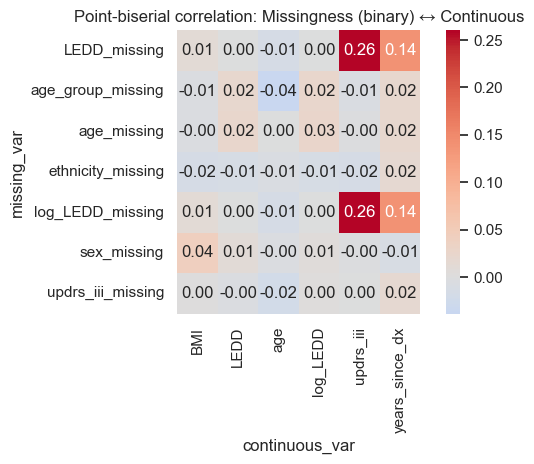

In [216]:

# -------------------------------------------
# 3) Point-biserial: continuous ↔ binary (missingness indicators vs continuous vars)
#    Returns both r and p-value for each pair
# -------------------------------------------
pb_results = []
for m in miss_cols:
    # ensure indicator is binary 0/1 (it is)
    mi = df_with_ind[m].astype(int)
    for x in num_cols:
        # Drop rows where the continuous variable is NA (indicator can be 0/1 regardless)
        valid = df_with_ind[x].notna()
        if valid.sum() > 2 and mi[valid].nunique() == 2:
            r, p = pointbiserialr(mi[valid], df_with_ind.loc[valid, x])
            pb_results.append({"missing_var": m, "continuous_var": x, "r_pb": r, "p_value": p})

pb_df = pd.DataFrame(pb_results).sort_values(["missing_var", "p_value"])

# Optional: display top associations (smallest p-values)
display(pb_df.head(20))

# Pivot to a heatmap of point-biserial r values
if not pb_df.empty:
    heat = pb_df.pivot(index="missing_var", columns="continuous_var", values="r_pb").fillna(0)
    plt.figure()
    sns.heatmap(heat, cmap="coolwarm", annot=True, fmt=".2f", center=0, square=True)
    plt.title("Point-biserial correlation: Missingness (binary) ↔ Continuous")
    plt.tight_layout()
    plt.show()



### How to read the results

* **Point-biserial `r_pb`** (−1 to +1):

  * Sign shows direction (e.g., `LEDD_missing` positively correlated with `years_since_diagnosis` means patients with longer disease duration are *more likely* to have LEDD missing).
  * Magnitude shows strength (roughly: 0.1 small, 0.3 medium, 0.5 large—rule of thumb).
* **`p_value`**: small p (e.g., `< 0.05`) suggests the association is unlikely due to chance.

> **Interpretation for missingness**
>
> * If several missingness indicators show **non-trivial** point-biserial correlations with observed continuous variables → **MCAR is unlikely**; **MAR is plausible** if you include those predictors in imputation/models.
> * If you find **no** notable associations → **MCAR** could be plausible (not proven).
>
>



 As you can see, LEDD missingness indicator is positively associated with years since diagnosis and UPDRS III scores, and have p-values < 0.05. This suggests that patients with longer disease duration and higher motor symptom severity are more likely to have missing LEDD values.

On the other hand, other missingness indicators (like UPDRS_III_missing, age_group_missing) do not show strong associations with any observed variables, suggesting that their missingness might be MCAR (Missing Completely At Random).

In [217]:

# -------------------------------------------
# 4) Categorical ↔ missingness : chi-squared
# -------------------------------------------
chi_rows = []
for m in miss_cols:
    for c in cat_cols:
        tab = pd.crosstab(df_with_ind[c], df_with_ind[m])
        if tab.shape[0] > 1 and tab.shape[1] > 1:
            chi2, p, dof, exp = chi2_contingency(tab)
            chi_rows.append({"missing_var": m, "categorical_var": c, "chi2": chi2, "p_value": p, "significant": p < 0.05, "dof": dof})

chi_df = pd.DataFrame(chi_rows).sort_values(["missing_var", "p_value"])
display(chi_df.head(20))


,missing_var,categorical_var,chi2,p_value,significant,dof
11,LEDD_missing,years_band,113.891274,1.595047e-24,True,3
9,LEDD_missing,sex,3.809760,5.095475e-02,False,1
12,LEDD_missing,age_group,0.163636,6.858304e-01,False,1
10,LEDD_missing,ethnicity,2.180696,7.025649e-01,False,4
23,age_group_missing,years_band,3.635744,3.035786e-01,False,3
22,age_group_missing,ethnicity,4.839640,3.041507e-01,False,4
21,age_group_missing,sex,0.001294,9.713093e-01,False,1
5,age_missing,years_band,3.334414,3.428815e-01,False,3
4,age_missing,ethnicity,3.146127,5.336760e-01,False,4
3,age_missing,sex,0.019057,8.902027e-01,False,1


We will provide full theory behind the Chi-square test and how to interpret test results in the next notebook, but for now, remember:
 * A low p-value (typically < 0.05) in the Chi-square test indicates that we can reject a null hypothesis (that there's no association) in favor of an alternative hypothesis (that there is an association) between the two categorical variables.
* If `p < 0.05`, missingness depends on `sex` → evidence **against MCAR** (supporting MAR).
* If `p >= 0.05`, no evidence of association → MCAR remains plausible.

### <span style="color:red; font-weight:bold"> 🍎 Student challenge </span>
<span style="color:red; font-weight:bold">Now your turn!</span>

Provide interpretation for the missingness patterns against the observed categorical variable from the chi-squred test results above.


Write your answer below:


### ✅ TL;DR

* Use **point-biserial** for **continuous ↔ binary** (perfect for missingness indicators).
* Use **chi-squared** for **categorical ↔ categorical** once you introduce it.
* Associations between missingness indicators and observed variables → **evidence against MCAR** and in favor of **MAR** (when those predictors are included).



## Little’s MCAR test

* **What it tests:** a **single, global null hypothesis** that **all** the missingness in the variables you include is **MCAR** (Missing Completely At Random).
* **What the p-value means:**

  * **p ≥ 0.05** → You do **not** see strong evidence against MCAR. MCAR is **plausible** for the *set as a whole* (not proven).
  * **p < 0.05** → You **reject** MCAR **somewhere** in that set. At least one variable’s missingness is **not MCAR** (could be MAR or MNAR). The test does **not** say which one.

> It does **not** give per-variable flags. Think of it as a smoke alarm for the whole block of variables you pass in.

## Does it handle continuous & categorical together?

* Yes, **in practice** you can include both by **encoding categoricals to numeric codes** (keeping NaNs).
* But under the hood, Little’s test relies on a model for multivariate data (often derived under approximate normality). Treat it as a **screening tool**, not a proof—especially when many categorical variables have many levels.

## What it does **not** tell you

* It doesn’t identify **which** variable violates MCAR.
* It doesn’t distinguish **MAR** vs **MNAR**.
* A “pass” (high p) doesn’t prove MCAR—it only says you didn’t detect evidence against it.

## How to use it in practice

1. **Run a global test** on the key analysis variables.
2. If **p < 0.05**, drill down:

   * Run **blockwise** tests (e.g., demographics only; labs only; outcomes only).
   * Check **associations** of each variable’s missingness indicator with observed variables (point-biserial/chi-square once introduced). This helps argue **MAR** for specific variables.




To use it, we need to install an additional library called `pyampute`, which provides an implementation of Little's MCAR test. You can install it using pip:

```python
!pip install pyampute

In [218]:
# uncomment if not installed
#!pip install pyampute 


## Code: Global Little test

In [219]:


import numpy as np
import pandas as pd
from pyampute.exploration.mcar_statistical_tests import MCARTest

def littles_mcar_test(df: pd.DataFrame, cols=None):
    """
    Run Little's MCAR test on selected columns of a DataFrame.
    - Encodes categoricals as integer codes (NaNs preserved)
    - Keeps only columns that have at least 1 missing value
    - Drops all-NaN or constant columns
    - Returns (p_value, used_columns)
    """
    # 1) choose columns: only those with any missing, unless user specified
    if cols is None:
        cols = [c for c in df.columns if df[c].isna().any()]
    if len(cols) == 0:
        raise ValueError("No columns with missing data selected.")

    X = df[cols].copy()

    # 2) encode categoricals to numeric codes (preserve NaNs)
    for c in X.select_dtypes(include=["object", "category"]).columns:
        codes = X[c].astype("category").cat.codes
        X[c] = codes.replace({-1: np.nan})  # -1 means NaN in pandas codes

    # 3) cast bool to int
    for c in X.select_dtypes(include=["bool"]).columns:
        X[c] = X[c].astype("float")

    # 4) drop columns that are all NaN or constant (no variance)
    drop_cols = []
    for c in X.columns:
        non_na = X[c].dropna()
        if non_na.empty or non_na.nunique() <= 1:
            drop_cols.append(c)
    if drop_cols:
        X = X.drop(columns=drop_cols)
    if X.shape[1] == 0:
        raise ValueError("All selected columns are all-NaN or constant after preprocessing.")

    # 5) run Little's test on the DataFrame (NOT .values)
    mt = MCARTest(method="little")
    pval = mt.little_mcar_test(X)  # <-- pass DataFrame, not array
    return float(pval), X.columns.tolist()

# --- Example usage ---
pval, used_cols = littles_mcar_test(df_clean)
print(f"Little's MCAR test p-value = {pval:.4f}")
print("Columns tested:", list(used_cols))

if pval < 0.05:
    print("→ Evidence against MCAR; investigate MAR/MNAR (use missingness indicators, point-biserial, etc.).")
else:
    print("→ MCAR is plausible (not proven). Still check other diagnostics.")


Little's MCAR test p-value = 0.0000
Columns tested: ['sex', 'age', 'ethnicity', 'LEDD', 'updrs_iii', 'log_LEDD', 'age_group']
→ Evidence against MCAR; investigate MAR/MNAR (use missingness indicators, point-biserial, etc.).


### “Blockwise”  follow-ups

In [220]:

# --- Blockwise helper: test logical groups to localize issues ---
def littles_by_blocks(df: pd.DataFrame, blocks: dict):
    """
    blocks = {
        "demographics": ["age", "sex", "race"],
        "labs": ["ldl", "hdl", "glucose"],
        "motor": ["updrs_iii", "updrs_total"],
        # ...
    }
    """
    out = []
    for name, cols in blocks.items():
        try:
            pval, used = littles_mcar_test(df, cols)
            out.append({"block": name, "p_value": pval, "n_cols": len(used)})
        except ValueError as e:
            out.append({"block": name, "p_value": np.nan, "n_cols": 0})
    return pd.DataFrame(out).sort_values("p_value", na_position="last")

# Example usage:
blocks = {"demographics": ["age","sex","ethnicity"],
          "disease": ["years_since_dx","updrs_iii","LEDD"]} 
littles_by_blocks(df_clean, blocks)


,block,p_value,n_cols
1,disease,0.000000,3
0,demographics,0.910217,3



### How to read these results

* **Global test p ≥ 0.05:** MCAR is plausible across the set tested. Still do your **association checks** (missingness indicators vs observed variables) because Little’s test can miss subtle structure or be conservative with small N.
* **Global test p < 0.05:** Something deviates from MCAR. Use:

  * **Blockwise** table to narrow down which domain drives the rejection.
  * **Association diagnostics** (e.g., **point-biserial** between each missingness indicator and continuous predictors) to argue **MAR** for specific variables.

---

## TL;DR

* Little’s test gives **one p-value** for the **whole set** you pass: it’s a **global MCAR screen**, not a per-column verdict.
* **High p**: MCAR **plausible** (not proven).
* **Low p**: **MCAR violated somewhere** (at least one variable); then use blockwise tests + associations with missingness-indicator associations to localize and argue **MAR**.
* It doesn’t separate **MAR vs MNAR**—use **substantive reasoning** and **sensitivity analyses** for that.




## 🧩 Handling Missing Data — Choosing the Right Approach


### 🔢 How much is missing?

A good rule of thumb:

| % missing (per variable) | Severity | Typical treatment                                                                         |
| ------------------------ | -------- | ----------------------------------------------------------------------------------------- |
| **< 5%**                 | Minor    | Dropping or simple imputation is usually fine.                                            |
| **5–20%**                | Moderate | Use regression or MICE imputation.                                                        |
| **> 20–30%**             | High     | Consider removing that variable or using advanced methods (MICE, model-based imputation). |
| **> 50%**                | Severe   | Usually drop that variable unless it’s critical and MNAR-adjusted models are possible.    |

---



## 🧰 Choosing the Right Technique



### 1️⃣ Dropping rows completely (`df.dropna()`)

**When to use:**

* Missingness is **MCAR** (truly random), **and**
* The % of missing rows is **small (<5%)**, **and**
* The variable isn’t critical for your analysis.

**Why it works:** Under MCAR, missingness is random, so dropping rows won’t bias results (just reduces sample size).
**Why it fails:** Under MAR or MNAR, the dropped rows are *not random*—you’ll bias the sample.

**Summary:** ✅ Safe only for **small, MCAR** missingness.


Two common methods are:

* **List-wise deletion**: Deleting the record (row) if the dataset has missing data in any of its variables/columns. This works best only when the missing data is small in number, like when in a dataset only 2% of the data is missing completely at random.

* **Pair-wise deletion**: Pairwise deletion only deletes rows when one of the variables being used in the statistical method that is considered, is missing. For example, if you are calculating the correlation between two variables (e.g. LEDD vs age), only the cases where either of the two variables is missing will be deleted. This method is more efficient than listwise deletion as it uses more of the available data.

In [221]:
# List-wise deletion: Drop any rows that contain missing values
df_drop = df_clean.dropna()
print("Before:", df_clean.shape, "| After drop:", df_drop.shape)

Before: (5300, 11) | After drop: (3954, 11)


In [222]:
# Pair-wise deletion: For demonstration, imagine we're going to compute correlation between 'LEDD' and 'updrs_iii'

pairwise_data = df_clean[["LEDD", "updrs_iii"]].dropna()
correlation = pairwise_data["LEDD"].corr(pairwise_data["updrs_iii"])
print(f"Pair-wise correlation between LEDD and UPDRS III: {correlation:.3f}")


Pair-wise correlation between LEDD and UPDRS III: 0.146


In [223]:
# you can also select the columns to drop in dropna() method
df_drop_selected = df_clean.dropna(subset=["LEDD", "updrs_iii"])
print("Before:", df_clean.shape, "| After drop (selected columns):", df_drop_selected.shape)

Before: (5300, 11) | After drop (selected columns): (4302, 11)


### 2️⃣ Simple Imputer (Mean/Median for numerical; Mode or custom categories for categorical)

**When to use:**

* Missingness is **MCAR** (or weakly MAR) and **low-to-moderate (<10%)**.
* Variable is **numerical**, and you need a quick, simple baseline.

**Mean vs. Median:**

| Use **mean** when                                | Use **median** when              |
| ------------------------------------------------ | -------------------------------- |
| Data are roughly symmetric and no large outliers | Data are skewed or have outliers |

**Add a missingness indicator:**
Always create a new binary variable `is_missing_X` = 1 if missing else 0.
This helps capture patterns if the missingness is mildly MAR.


**Why not for MAR/MNAR:**
Mean/median imputation distorts relationships and variance, leading to biased regression coefficients.

**Summary:** ✅ OK for **small MCAR**, ⚠️ crude for **MAR**, ❌ not for **MNAR**.


In [224]:


num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# exclude _missing columns if any
num_cols = [c for c in num_cols if not c.endswith("_missing")]
df_simp_impute = df_clean.copy()

# Create missingness indicators all columns
for col in df_simp_impute.columns:
    df_simp_impute[f"is_missing_{col}"] = df_simp_impute[col].isna().astype(int)



You can impute either using `SimpleImputer` from `scikit-learn` library


In [225]:
# Simple Imputer with median strategy
from sklearn.impute import SimpleImputer


# Impute using median strategy
imputer = SimpleImputer(strategy="median")  # or "mean"

df_simp_impute[num_cols] = imputer.fit_transform(
    df_simp_impute[num_cols]
)



Or you can use the inherent pandas methods for simple imputation such as `.fillna()`

In [226]:
# use fillna with the mean 

df_simp_impute[num_cols] = df_simp_impute[num_cols].fillna(df_simp_impute[num_cols].mean())

#### Categorical — Fill categories with a constant (e.g., “Unknown”) or the mode
In categorical variables, you can impute missing values with the most frequent category (mode) or create a new category like "Unknown" to represent missingness. We can similarly do it with a pandas `.fillna()` one-liner:

In [227]:
# impute categorical columns with most frequent value
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()
df_simp_impute[cat_cols] = df_simp_impute[cat_cols].fillna(
    df_simp_impute[cat_cols].mode().iloc[0]
)

# or you can use 'Unknown' for categorical columns
# df_simp_impute[cat_cols] = df_simp_impute[cat_cols].fillna('Unknown')

Or with `SimpleImputer` from `scikit-learn`:

In [228]:
# Use Simple Imputer with 'Uknown' strategy for categorical columns
cat_imputer = SimpleImputer(strategy="constant", fill_value="Unknown")

# or you can use 'most_frequent' strategy for categorical columns
#cat_imputer = SimpleImputer(strategy="most_frequent")

df_simp_impute[cat_cols] = cat_imputer.fit_transform(df_simp_impute[cat_cols])




#### 🧮 Check that it worked

In [229]:
df_simp_impute.isna().sum()

patient_id                   0
sex                          0
years_since_dx               0
age                          0
ethnicity                    0
BMI                          0
LEDD                         0
updrs_iii                    0
log_LEDD                     0
years_band                   0
age_group                    0
is_missing_patient_id        0
is_missing_sex               0
is_missing_years_since_dx    0
is_missing_age               0
is_missing_ethnicity         0
is_missing_BMI               0
is_missing_LEDD              0
is_missing_updrs_iii         0
is_missing_log_LEDD          0
is_missing_years_band        0
is_missing_age_group         0
dtype: int64

#### 3️⃣ Quick Visual Check Before and After Imputation

We can look at how imputation changes a variable’s distribution — here for LEDD.

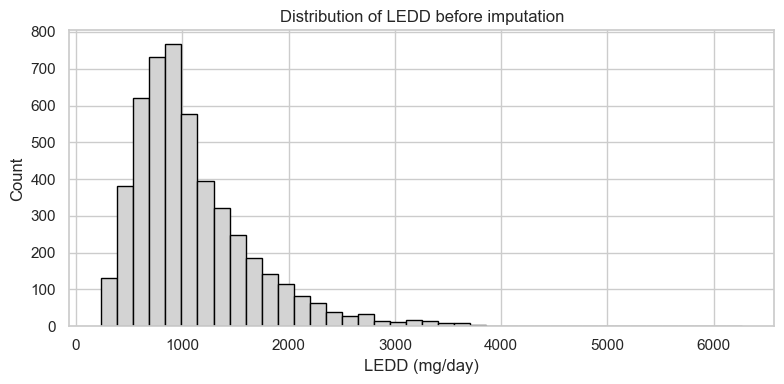

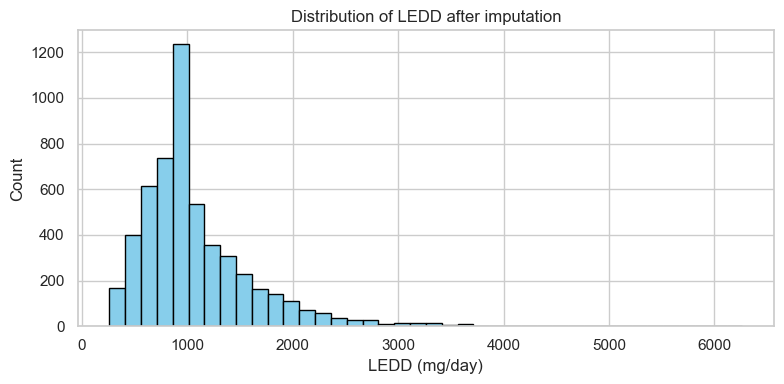

In [230]:
plt.figure(figsize=(8, 4))
plt.hist(df["LEDD"].dropna(), bins=40, edgecolor="black", color="lightgrey")
plt.title("Distribution of LEDD before imputation")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(df_simp_impute["LEDD"], bins=40, edgecolor="black", color="skyblue")
plt.title("Distribution of LEDD after imputation")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



> 💡 **Note:** Mean or median imputation doesn’t “invent” information — it just makes the dataset usable for analysis.
> For serious clinical modeling, you’d later learn more advanced approaches (like *multiple imputation* or *model-based* filling).


## 🚀 Advanced Imputation 

So far, we’ve used **simple univariate imputation** (mean, median, or mode).
This works when missingness is *small* and *completely at random (MCAR)*, but it can distort relationships between variables and underestimate variance.

To better preserve *correlations, variability, and multivariate structure*, we can use **model-based** or **multiple imputation** methods — especially when missingness is **MAR (Missing at Random)**.

---

#### 🧠 Why go beyond simple imputation?

| Method                                              | When to use                                                                               | How it works                                                                                                           | Pros                                                                                     | Cons                                                                 |
| --------------------------------------------------- | ----------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | -------------------------------------------------------------------- |
| **Mean / median / mode**                            | Small amount of missing data, MCAR                                                        | Replace missing values with a constant (mean/median for numeric, mode for categorical)                                 | Simple, fast                                                                             | Reduces variance, distorts correlations, biased under MAR            |
| **Linear (regression) imputation**                  | Continuous variable missing, depends on *other continuous predictors*                     | Fit a linear model (Y ~ X₁ + X₂ …) to predict missing values                                                           | Preserves linear relationships                                                           | Assumes linearity, may overfit if predictors weak                    |
| **Logistic / Multinomial regression imputation**    | Categorical variable missing, depends on *continuous or categorical predictors*           | Fit a logistic (binary) or multinomial model to predict class probabilities and draw imputed category                  | Handles categorical targets; captures MAR structure                                      | More complex; requires encoding predictors; uncertainty if few cases |
| **MICE (Multiple Imputation by Chained Equations)** | Several variables (numeric & categorical) have missingness, possibly interdependent (MAR) | Iteratively models each variable using the others — linear models for continuous, logistic/multinomial for categorical | Preserves multivariate structure, supports mixed data                                    | Computationally heavier; assumes MAR                                 |
| **Random Forest MICE (e.g., `miceforest`)**         | Mixed numeric + categorical data with nonlinear relationships                             | Uses random forest models for each variable during MICE iterations                                                     | Captures nonlinear & interaction effects; handles categorical ↔ categorical dependencies | Slower on large data; requires categorical dtype setup               |

#### 🔍 Choosing the right approach

| Data type                                               | Missingness pattern                     | Suggested method                                         | Notes                                        |
| ------------------------------------------------------- | --------------------------------------- | -------------------------------------------------------- | -------------------------------------------- |
| Continuous (MCAR, small %)                              | MCAR                                    | Mean/median                                              | Quick fix; minimal bias if truly random      |
| Continuous (MAR)                                        | MAR (depends on other vars)             | Linear regression imputation or MICE                     | Preserves relationships                      |
| Categorical (MCAR)                                      | Random missing labels                   | Mode                                                     | Acceptable if random and small %             |
| Categorical (MAR, depends on continuous or categorical) | Missingness linked to age, cohort, etc. | Logistic / Multinomial regression or MICE (`miceforest`) | Retains relationships, avoids bias           |
| Mixed (both numeric + categorical, interdependent)      | MAR                                     | MICE / Random forest MICE (`miceforest`)                 | Best all-round method for realistic datasets |




#### 🧠 Key takeaways

* **Regression-based imputation** (linear, logistic) uses predictive modeling to infer plausible values.
* **MICE** performs this iteratively for *all* variables, cycling through models until convergence.
* **Categorical imputation**:

  * Uses **logistic** models (binary) or **multinomial** models (multiclass).
  * When the missing variable *depends on another categorical variable*, one-hot encoding or a **random forest**–based MICE can capture those dependencies automatically.
* **Random forest MICE (`miceforest`)** handles numeric and categorical variables natively — ideal for datasets with nonlinear or interaction effects (e.g., *sex × cohort type* influencing missing UPDRS scores).

### ⚠️ Which variables to include in imputation models?
* Substantive analysis variables: all predictors, outcomes, and key covariates that will enter your downstream statistical tests. (This avoids incompatibility/bias.)
* Auxiliary variables: anything correlated with the target variable or with the probability of being missing (even if not used in the final model). These improve plausibility of MAR and imputation efficiency.
* Nonlinear terms & interactions if they’re in your analysis model (or clearly needed). In MICE, add them as separate columns (“passive imputation” for derived variables).
* Reasonably observed variables (e.g., <60–70% missing). Heavily missing vars can still be included in MICE, but if a column is ~95% missing it contributes little and can destabilize—consider dropping 

> Always **diagnose imputation quality**: compare distributions before/after, check correlations, and validate on held-out data if possible.






### 4️⃣ Linear Regression Imputer

**When to use:**

* Missingness is **MAR**, and
* The variable to impute has **linear or monotonic relationships** with other observed variables, and
* Missingness proportion is **moderate (5–20%)**.

**Why it works:**
It uses information from observed variables (predictors) to estimate missing values—exactly what the MAR assumption allows.

**Caution:**
Don’t impute your outcome variable (the one you’re trying to predict). Use it mainly for covariates or features.

**Summary:** ✅ Good under **MAR**, ❌ invalid under **MNAR**, unnecessary for **MCAR** (simpler methods suffice).

#### How to use Linear Regression Imputation

Let's go back to our correlation checks for a second. Remember that we found that LEDD missingness was correlated with years since diagnosis and UPDRS III scores?

In [232]:
# show that LEDD missing indicators are correlated with updrs_iii values and years_since_dx
df_with_ind[["LEDD_missing", "updrs_iii", "years_since_dx"]].corr()

,LEDD_missing,updrs_iii,years_since_dx
LEDD_missing,1.000000,0.260152,0.13933
updrs_iii,0.260152,1.000000,0.47400
years_since_dx,0.139330,0.474000,1.00000


We can use those variables to impute the missing LEDD values using a **linear regression model**.

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make a copy to work with
df_linimp = df_with_ind.copy()

# Define features and target
features = ["years_since_dx", "updrs_iii", "age", "BMI"]
target = "LEDD"

# 1) Separate rows with and without missing LEDD
mask_missing = df_linimp[target].isna()
train_df = df_linimp.loc[~mask_missing, features + [target]].dropna()
predict_df = df_linimp.loc[mask_missing, features].dropna()

# 2) Fit linear model on complete cases
lin_model = LinearRegression()
lin_model.fit(train_df[features], train_df[target])

# 3) Predict missing LEDD
predicted = lin_model.predict(predict_df[features])
df_linimp.loc[predict_df.index, target] = predicted

print(f"Imputed {len(predicted)} missing LEDD values using linear regression.")

Imputed 490 missing LEDD values using linear regression.


**When to use:**

* When missingness is likely **MAR** (depends on other observed variables).
* When predictors (like disease duration or motor severity) are good correlates of the target.

**Advantages:**

* Preserves relationships between variables.
* Doesn’t collapse variability as mean imputation does.

**Limitations:**

* Assumes linearity.
* Only imputes one variable at a time (univariate target).




### 5️⃣ MICE (Multiple Imputation by Chained Equations)

**Motivation:**
When several variables (e.g., `LEDD`, `UPDRS_III`, `age`) are missing at once, imputing one variable at a time using the others iteratively better reflects their mutual relationships.

**When to use:**

* Missingness is **MAR**,
* Missingness is **moderate or high (5–30%)**,
* You want valid statistical inference or correlation preservation.

**Why it works:**
MICE models each variable with missing values conditionally on the others, repeating the process multiple times.
It captures relationships among variables and uncertainty in imputation.

**When not ideal:**
If you strongly suspect **MNAR** and can’t model the missingness process directly (e.g., people with higher true values missing), MICE can still bias results.

**Important caveat:**
* You need to convert all categorical variables into numeric codes before using MICE. This process is called **encoding** (e.g., label encoding or one-hot encoding). It means that each category is represented by a unique number (e.g. "white" - 0, "black" - 1, "asian" - 2), allowing MICE to process them correctly. It can be done using `.get_dummies()` or `LabelEncoder` from `sklearn`.
* You can include both columns with missing data and fully observed columns as predictors in the MICE imputation model. Including fully observed columns can help improve the accuracy of the imputations for the variables with missing data.


**Summary:** ✅ Best choice for **MAR**, ⚠️ approximates MNAR with sensitivity analyses, ❌ overkill for small, purely MCAR missingness.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

df_imp = df.copy()

# 1) One-hot encode categoricals as predictors (include a dummy for NaN)
sex_dum = pd.get_dummies(df_imp["sex"], prefix="sex", drop_first=False, dummy_na=True)
eth_dum = pd.get_dummies(df_imp["ethnicity"], prefix="eth", drop_first=False, dummy_na=True)

# 2) Build design matrix: numeric targets + one-hot predictors
num_targets = ["LEDD", "updrs_iii", "age", "BMI", "years_since_dx"]
X = pd.concat([df_imp[num_targets], sex_dum, eth_dum], axis=1)

# 3) Impute only the numeric targets (first columns); dummies act as predictors only
imputer = IterativeImputer(random_state=0, max_iter=10)
X_imputed = imputer.fit_transform(X)

# 4) Put imputed numeric values back
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=df_imp.index)
df_imp[num_targets] = X_imputed[num_targets]

df_imp.head()


,LEDD,updrs_iii,age,years_since_dx,sex_one_hot
0,818.300000,44.900000,66.6,10.62,0.0
1,911.936129,31.957703,52.5,8.29,0.0
2,1242.933872,27.852806,63.4,5.78,1.0
3,1683.987581,34.412344,70.2,8.15,1.0
4,788.200000,35.400000,53.4,10.03,0.0




**What it does (in simple terms):**

1. Start by filling missing values with simple guesses (e.g., means).
2. Pick one variable with missing values (e.g., `LEDD`).
3. Predict its missing values using all other variables in the dataset.
4. Repeat this for each variable with missing data, cycling through several times.

After several iterations, the imputations stabilize.

### 🔍 Compare LEDD Distributions (before vs after imputation)

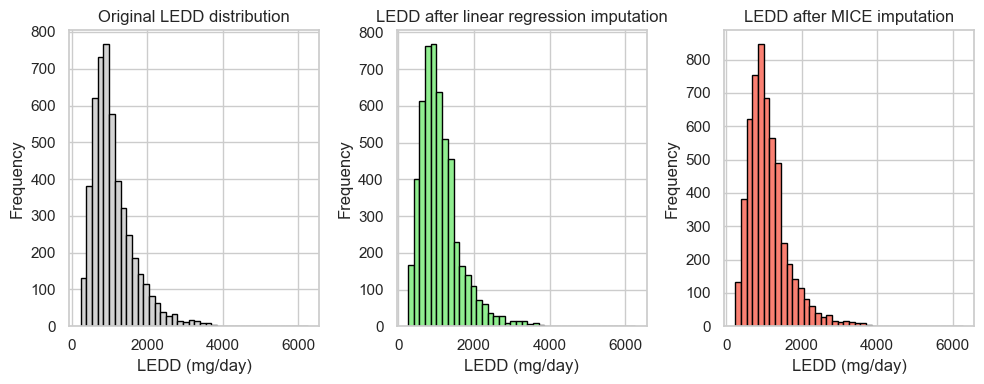

In [ ]:
import matplotlib.pyplot as plt 

# Compare LEDD distributions before and after imputation on different subplots

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(df["LEDD"].dropna(), bins=40, edgecolor="black", color="lightgrey")
plt.title("Original LEDD distribution")
plt.xlabel("LEDD (mg/day)"); plt.ylabel("Frequency")            
plt.subplot(1,3,2)
plt.hist(df_linimp["LEDD"], bins=40, edgecolor="black", color="lightgreen")
plt.title("LEDD after linear regression imputation")
plt.xlabel("LEDD (mg/day)"); plt.ylabel("Frequency")
plt.subplot(1,3,3)
plt.hist(df_imp["LEDD"].dropna(), bins=40, edgecolor="black", color="salmon")
plt.title("LEDD after MICE imputation")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# Visualise the pairwise relationships between numeric variables    


**Interpretation:**

* Linear imputation and MICE maintain more realistic LEDD variability.
* Compare with simple mean/median imputation — those would produce artificial spikes.
* Always inspect histograms to check plausibility of imputed values.


### 🧩 Categorical Imputation with Models

When a **categorical variable** has missing values, simple strategies (mode or “Unknown”) can bias inference. Two principled options:

* **Model-based single imputation**

  * **Binary** outcome → *logistic regression*
  * **Multiclass** outcome → *multinomial (softmax) logistic regression*
* **Multiple imputation** via **MICE** that natively handles categorical features → `miceforest`

> Tip: If your downstream analysis is inferential (regression/hypothesis tests), **multiple imputation** is preferred so you can pool estimates (Rubin’s rules).


Quick Decision Guide

| Goal                        | Missingness     | Target type         | Suggested method                                   |
| --------------------------- | --------------- | ------------------- | -------------------------------------------------- |
| Simple           | MCAR / mild MAR | Binary / Multiclass | Logistic / Multinomial         |
| Inference (publishable)     | MAR             | Binary / Multiclass | **MICE via `miceforest`**, pool with [Rubin’s rules](https://medium.com/data-science-collective/mice-the-smart-way-to-handle-missing-data-in-machine-learning-0052d072267a) |
| Many categorical predictors | MAR             | Any                 | `miceforest` (handles interactions, nonlinearity)  |
| Ordinal outcome             | MAR             | Ordinal             | [Ordinal logistic](https://analyticsindiamag.com/ai-trends/a-complete-tutorial-on-ordinal-regression-in-python/) (or multinomial with note)        |

---

### 6️⃣ Logistic / Multinomial Regression Imputation (Single Imputation)

Use this when you want a simple, explicit model for the missing categorical variable. Works when the missingness is **MCAR/MAR**.

#### A) Binary target (e.g., `sex`: Female/Male)
* Predictors can be numeric or categorical.
* If predictors include categorical variables, **one-hot encode** them.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

df_logit = df.copy()

target = "sex"
num_feats = ["BMI", "LEDD", "updrs_iii", "years_since_dx", "age"]
cat_feats = ["ethnicity"]  # will be one-hot encoded

# Train on rows where target is observed; we also require predictors present
mask_miss = df_logit[target].isna()
mask_train = (~mask_miss) & df_logit[num_feats + cat_feats].notna().all(axis=1)
mask_test  = (mask_miss) & df_logit[num_feats + cat_feats].notna().all(axis=1)

X_train = df_logit.loc[mask_train, num_feats + cat_feats] # Sometimes also called X_obs - observed features
y_train = df_logit.loc[mask_train, target].astype(str) # Sometimes also called y_obs - observed target
X_test  = df_logit.loc[mask_test,  num_feats + cat_feats] # Sometimes also called X_mis - features where target is missing, which we're trying to impute

# Preprocess: scale numerics, one-hot encode ethnicity (keeps NaN as its own level if seen in fit)
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop=None), cat_feats),
    ],
    remainder="drop"
)

pipe = Pipeline([
    ("pre", pre),
    ("model", LogisticRegression(max_iter=300, solver="lbfgs"))
])

pipe.fit(X_train, y_train)

# Predict class probabilities and sample (stochastic imputation)
proba = pipe.predict_proba(X_test)
classes = pipe.named_steps["model"].classes_
rng = np.random.default_rng(0)
draws = [rng.choice(classes, p=p) for p in proba]

# Fill back the imputed values
df_logit.loc[mask_test, target] = draws

print("Logistic regression imputation complete.")
print("Remaining missing in 'sex':", df_logit["sex"].isna().sum())


#### B) Multiclass target (e.g., `ethnicity`: White/Black/Asian/Other)
Same idea, just switch to multinomial:

In [ ]:

df_imp = df.copy()

# ---- Target + features ----
target = "ethnicity"  # multiclass target to impute
num_feats = ["BMI", "LEDD", "updrs_iii", "years_since_dx", "age"]
cat_feats = ["sex"]   # categorical predictor

# ---- Build masks ----
mask_miss = df_imp[target].isna()

# We'll impute only rows where predictors are present (or can be imputed in-pipe)
# Using SimpleImputer in the pipeline means we *don't* need to pre-drop rows.
mask_train = ~mask_miss
mask_test  = mask_miss

X_train = df_imp.loc[mask_train, num_feats + cat_feats]
y_train = df_imp.loc[mask_train, target].astype(str)

X_test  = df_imp.loc[mask_test,  num_feats + cat_feats]

# ---- Preprocess: impute + scale numerics, impute + one-hot categoricals ----
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler()),
        ]), num_feats),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh",  OneHotEncoder(handle_unknown="ignore", drop=None)),
        ]), cat_feats),
    ],
    remainder="drop"
)

# ---- Multinomial logistic (works for >2 classes) ----
multi = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=400,
    class_weight=None  # or "balanced" if classes are very imbalanced
)

pipe = Pipeline([("pre", pre), ("clf", multi)])

# Fit
pipe.fit(X_train, y_train)

# Predict probabilities for the rows we plan to impute
proba   = pipe.predict_proba(X_test)
classes = pipe.named_steps["clf"].classes_

# Stochastic draw from predicted probabilities (better than argmax)
rng = np.random.default_rng(0)
draws = np.array([rng.choice(classes, p=p) for p in proba])

# ---- CRITICAL: assign back by the SAME INDEX you predicted on ----
df_imp.loc[X_test.index, target] = draws

print("Multinomial imputation complete.")
print("Remaining missing in 'ethnicity':", df_imp["ethnicity"].isna().sum())




### 🧩 Random Forest MICE (`miceforest`) for Mixed Categorical + Continuous

Behold, the superstar of imputation methods!

If you get tired of figuring out how to impute each variable type separately, especially when you have a mix of **categorical** and **continuous** variables with complex relationships, **Random Forest MICE** is your friend.

> When both **categorical** and **continuous** variables have missingness, and relationships may be **nonlinear** or **interdependent**, the best choice is **Multiple Imputation by Chained Equations (MICE)** using `miceforest`.

In [ ]:
# 🧠 Multiple Imputation by Chained Equations (Random Forest)
!pip install miceforest

In [ ]:

import miceforest as mf

# Drop columns with extreme missingness (none in this dataset, but keep flexible)
df_mice = df.copy()

# Convert to category dtype for mixed data handling
for col in ["sex", "ethnicity", "patient_id"]:
    df_mice[col] = df_mice[col].astype("category")
    

# Initialize MICE kernel
kernel = mf.ImputationKernel(
    df_mice,
    random_state=42
)

# Run chained equations (5 iterations × 3 imputed datasets)
kernel.mice(m=3, iterations=5)

# Retrieve one completed dataset for analysis
df_mice_imp = kernel.complete_data(dataset=0)

print("✅ miceforest imputation complete.")
print(df_mice_imp[["sex", "ethnicity"]].isna().sum())


**Why this is so versatile**

* No need to encode categoricals manually (`.astype("category")` is enough).
* Learns both *categorical ↔ continuous* and *categorical ↔ categorical* relationships.

  * e.g. `ethnicity` missingness depending on `sex` and `age`.
* Produces multiple plausible completed datasets — useful for demonstrating [Rubin’s rules pooling.](https://bookdown.org/mwheymans/bookmi/rubins-rules.html)

### 🧮 Compare before and after missingness

In [ ]:
def missing_summary(df_in, label):
    miss = df_in.isna().mean() * 100
    print(f"\n--- Missingness after {label} ---")
    print(miss[miss > 0].round(2))

missing_summary(df, "original")
missing_summary(df_logit, "logistic imputation")
missing_summary(df_mice_imp, "miceforest imputation")

---

### 🧩 Summary Cheat Sheet

| Missingness Type | % Missing | Recommended Techniques                                             | Avoid                          |
| ---------------- | --------- | ------------------------------------------------------------------ | ------------------------------ |
| **MCAR (<5%)**   | Small     | Drop rows ✅, Simple mean/median ✅, MICE optional                   | Complex modeling (unnecessary) |
| **MCAR (5–20%)** | Moderate  | Simple imputer (mean/median) ✅ with missingness flag               | Dropping many rows             |
| **MAR (<5%)**    | Small     | Regression or MICE ✅                                               | Simple mean/median (biased)    |
| **MAR (5–30%)**  | Moderate  | **MICE** (best), Regression imputation ✅                           | Dropping or mean imputation    |
| **MNAR (any%)**  | Any       | **Sensitivity analysis, selection models, pattern-mixture models** | Regular MICE or mean (biased)  |



### 🧪 Practical takeaway

1. **Start with diagnostics:**

   * If MCAR → drop or mean/median is fine (for small %).
   * If MAR → regression or MICE.
   * If MNAR → can’t fix directly; do sensitivity analyses.

2. **Consider how much is missing:**

   * <5%: simple methods okay.
   * 5–20%: regression or MICE.
   * > 30%: MICE or rethink variable.

3. **Always validate**:
   Compare results from simple and advanced methods. If conclusions change, missingness matters.



---
### How to proceed on a real project (step-by-step)

1. **Describe the missing data**

   * Percent missing per variable; 
   * Patterns?
      * Monotone (e.g. missing data follows a specific order) vs Sporadic (e.g. missing data is random)?
      * By time (e.g is data missing more frequently at certain times or at later dates?) or clinical site (do certain sites have more missing data?).

2. **Diagnose MCAR vs MAR**

   * Run **Little’s MCAR test** (if software provides it). If it rejects MCAR, don’t do complete-case unless justified otherwise.
   * Build missingness indicators and test associations with observed variables.
3. **Choose the main analysis strategy**

   * If MCAR seems plausible → complete-case or simple imputation.
   * Otherwise assume **MAR** and use **MICE/Linear Regression Imputation** with a rich set of predictors.
4. **Run sensitivity analyses for MNAR**

   * Try delta adjustments or pattern-mixture assumptions to see how robust your results are if nonresponders differ systematically.
5. **Report transparently**

   * Which assumption (MCAR/MAR/MNAR) you relied on, what diagnostics you ran, and how sensitive results were.

---



### <span style="color:red; font-weight:bold"> 🍎 Student challenge </span>
<span style="color:red; font-weight:bold">Now your turn!</span>

Now we're going to apply what we've learned about missing data to another dataset.
This dataset contains bloodwork results (single-visit; cross-sectional) for a group of patients, with some values missing. The **variables include:**
* `patient_id` - patient identifier,
* `site (A/B/C)` - clinic site identifier
* `clinic_day (Mon–Fri)` - day of the week when the clinic visit occurred
* `age`, `sex`, `ethnicity` - patient demographic features
* `education_years` - years of formal education
* `bmi` - body mass index (kg/m²),
* `years_since_dx` - years since diagnosis
*`LEDD (mg/day)`, `updrs_iii (0–132)` - PD-related clinical measures
* `CRP (mg/L)`, `ALT (U/L)` - bloodwork lab results
* `household_income (USD)` - annual household income



Using the provided dataset `pd_bloodwork.csv`, please carry out the following tasks:


### 1) **Map the missingness**

* Compute **% missing per column**, and a quick **missingness map** (you showed how).
* Classify **item vs. unit nonresponse**: notice that some patients/rows may be absent — why?
 > Hint, check the variables for which we know the value range

> **Deliverable:** a table of missingness rates; 2–3 sentences about which variables look “safe” (small MCAR-like) vs. “concerning” (non-random).





In [ ]:
# Write your code here: 

Interpretation template:
* Note which variables are modestly vs moderately vs heavily missing.
* Check if unit nonresponse exists (severe patients may be absent entirely from observed).

Answer: 


### 2) **MCAR screen with Little’s test (global)**

* Run **Little’s MCAR test** on a set of key variables (install `pyampute` if you want to run it).
* Interpret **one global p-value** (smoke alarm, not per-variable).

> **Deliverable:** global p-value and a sentence: “MCAR plausible?” If **rejected**, note “somewhere it’s not MCAR.”


In [ ]:
# Write your code here: 

### 3) **Association diagnostics (per variable)**

* Create **missingness indicators** (0/1) for each target variable.
* **Point-biserial** (**continuous ↔ missingness**) for pairs like:

  * `LEDD_missing` vs `years_since_dx`, `updrs_iii`, `age`, `bmi`
  * `updrs_iii_missing` vs `age` …
* **Chi-squared** (**categorical ↔ missingness**) when you introduce it:

  * e.g., `LEDD_missing` vs `site`, `clinic_day`, `sex`, `ethnicity`.

> **Deliverable:** a concise table of strongest associations (per variable), with point-biserial r and p-values; chi-squared stats and p-values.
> **Interpretation:** where we see associations → **MCAR unlikely**; **MAR plausible** when those predictors are included.

In [ ]:
# Write your code here:

#### Write your interpretation below:




### 4) **Choose imputation strategies (by variable & % missing)**



> **Deliverable:** a brief plan per variable (method + predictors included).

#### Write your imputation plan below:


### 5) **Do it**: impute and compare methods

Implement your imputation plan using appropriate methods (e.g., MICE, linear regression imputer, simple imputer).

> **Deliverables:**
> * Imputed dataset saved as `pd_bloodwork_imputed.csv`.
> * Histograms comparing original vs imputed distributions for **CRP**, **LEDD**, and **UPDRS III**.
> * A small table for income means under **MAR** and **delta shifts** (+5k, +10k, +20k).

**HINT**: You can encode categorical variables (e.g., `site`, `clinic_day`, `sex`, `ethnicity`) using one-hot encoding or label encoding before imputation. Use .get_dummies() for this! 
We will release the true dataset with no missingness later for you to compare your imputed values against the ground truth! 

In [ ]:
# Write your code here: 



# 📖 A Practical Guide to Data Cleaning in Medical Data

### Handling Outliers and Missing Data Responsibly
After covering all of the data cleaning techniques, you might be wondering - when do I use which technique? Your roadmap is heavily tied to the analysis you plan to do downstream, the type of data you have, and the nature of the outliers/missingness. 
Let's put it all together! Let's summarize a practical guide to handling outliers and missing data in medical datasets.

---

## 1) First, classify what you’re looking at

### **Outliers**

* **Blatant data error** — impossible or out-of-scale (e.g., age = −3, UPDRS III = 999).
  → not biology, it’s a typo.
* **Valid but extreme** — plausible but rare (e.g., very high LEDD, very low UPDRS III in early PD).
  → may carry clinical meaning.
* **Structural** — a different population or process (e.g., post-DBS vs. pre-DBS patients).
  → may need to be analyzed separately.

### **Missingness**

* **MCAR** — missing completely at random; unrelated to other variables.
* **MAR** — missing at random; related to observed variables (e.g., older age ⇒ more missing UPDRS).
* **MNAR** — missing not at random; depends on the unobserved value itself (e.g., very severe patients skip tests).

---

## 2) What to do with outliers

### A. **Use statistical rules to *flag*, not auto-remove**

Techniques like **IQR fences**, **z-scores (±3 SD)**, **MAD-z**, or **quantile cuts (1st/99th%)** are *screening tools*.
They identify potential outliers — they don’t decide the fate of the data.

Once flagged, decide which category the point belongs to:

| Case                                         | Example                              | Action                                                               |
| -------------------------------------------- | ------------------------------------ | -------------------------------------------------------------------- |
| **Impossible / data entry error**            | UPDRS III = 999, Age = −2            | → **Set to NaN**, handle via missing-data strategy                   |
| **Clearly mis-keyed**                        | LEDD = 20000 (extra zero)            | → **Set to NaN**, maybe verify/correct if obvious                    |
| **Plausible extreme**                        | LEDD = 1800, UPDRS = 5               | → **Keep** (valid tail); use **robust methods**, maybe log-transform |
| **Extreme but distorting a sensitive model** | One huge LEDD value drives statistical test results (e.g. Student's t-test)| → **Winsorize** or transform; **run sensitivity check**              |
| **Duplicate / wrong cohort**                 | Follow-up visit in baseline table    | → **Drop or separate** by rule. Or aggregate visits by patient ID (if it's withing the purpose of your project, e.g. you're looking at mean LEDD across visits for year 1 since PD diagnosis)  |

> **Never automatically drop or NaN values just because they exceed a z-score or IQR fence.**
> Outlier detection ≠ outlier deletion.

---

### B. **Swap to NaN (and later impute) when:**

* The value is **impossible** or **out of valid range**.
* The value is **unmappable** after recoding (e.g., “sex = 10”).
* It clearly belongs to a **wrong data source or population**.

---

### C. **Omit (drop rows)** only when:

* The record is **duplicated or corrupted** beyond repair.
* The variable is **critical** and missing/impossible in that record.
* The proportion dropped is **tiny** and plausibly MCAR — and you document it.

---

### D. **Winsorize or cap** when:

* You need **stable summaries or linear models** that blow up under heavy tails.
* The cutoff is **pre-defined and domain-justified** (e.g., LEDD capped at 2,000 mg/day for non-advanced PD).
* You’ll **also re-run** key results *without* winsorization to show robustness.

> **Rule of thumb:** Winsorize for *reporting clarity or model stability*, not to “fix” significance.

---

### E. **Prefer robust alternatives first**

Use methods that make outlier handling less arbitrary (we will cover some of these these in more detail in the follwing notebook, treat it as a teaser :) ):

* Robust summaries: **median, IQR, [trimmed mean](https://statisticsbyjim.com/basics/trimmed-mean/)**
* Robust tests/regressions: **quantile**, **rank-based**, **bootstrap CI**, [**Huber regression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)
* Nonparametric associations: [k](https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/spearman-rank-correlation-definition-calculate/), [**Kendall**](https://www.statisticshowto.com/kendalls-tau/), [**Cliff’s delta**](https://real-statistics.com/non-parametric-tests/mann-whitney-test/cliffs-delta/)
* Transformations when interpretable: **log-transform**,[**Box-Cox**](https://builtin.com/data-science/box-cox-transformation-target-variable), etc.

---

## 3) What to do with missing values

### A. **Listwise/pairwise deletion**

Use only if:

* Missingness is **MCAR**, small (<5%), and sample size remains comfortable.
* You’re doing quick descriptive summaries with minimal bias risk.

### B. **Simple (single) imputation**

* Acceptable for **prototyping or visualization**, not for inference.
* Add **missingness indicators** if “missing” may carry signal (e.g., nonattendance = disease severity).

### C. **Multiple imputation (MICE, etc.)**

* Recommended when data are **MAR** (typical in clinical data).
* Include **related predictors** (e.g., age, sex, disease duration) to improve imputation quality.
* Perform **within each training fold** (to avoid leakage).

### D. **MNAR cases**

* Avoid blind imputation.
* Use **sensitivity analyses** (e.g., worst-case, delta adjustments).
* When possible, **model the mechanism** or **acknowledge potential bias**.

---

## 4) When to clean vs. when to analyze raw

* Always **inspect raw data first** — visualize ranges, histograms, and missingness.
* **Write and save cleaning rules** — thresholds, recode tables, duplicate logic.
* Maintain both:

  * `raw_df` (untouched)
  * `clean_df` (with scripted preprocessing)

---

## 5) Timing by task
This might not make sense now, but as you progress in your data analysis journey (with later notebooks and modules), you will understand why this is important. Different tasks have different tolerances for outliers and missingness. Tailor your cleaning accordingly.

### **Descriptive statistics & visualization**

* **NaN-out impossible values** only.
* Show both **raw and trimmed** views if extremes clutter the plot.
* Use **robust metrics** (median, IQR, 5th–95th %).
* Optionally **winsorize for readability only**, and note it in captions.

### **Statistical inference (correlations, group tests, regressions)**

* Convert **errors → NaN**, then handle missingness.
* Use **robust tests** by default:

  * Continuous–continuous: [**Spearman**](https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/spearman-rank-correlation-definition-calculate/) (or [Kendall](https://www.statisticshowto.com/kendalls-tau/) if many ties)
  * Binary–continuous: [**Welch t-test**](https://www.statology.org/welchs-t-test/), [**Brunner–Munzel**,](https://www.statisticshowto.com/brunner-munzel-test-generalized-wilcoxon-test/) report **Cliff’s delta**
  * Categorical–categorical: [**χ²**](https://www.scribbr.com/statistics/chi-square-tests/) (check expected counts), or [**Fisher’s exact**](https://www.technologynetworks.com/tn/articles/the-fishers-exact-test-385738) if sparse; report **φ / Cramer’s V**
* Apply transformations (e.g., log-LEDD) when justified.

### **Machine learning**

* Split first → **impute and scale inside folds**.
* Use models robust to missingness/outliers (e.g., **trees, boosting**).
* Add **missingness indicators** when “missing” is informative.
* Avoid global winsorization before splitting — that leaks information.

---

## 6) Quick decision cheatsheet

| Situation                  | Action                                                 |
| -------------------------- | ------------------------------------------------------ |
| Outlier impossible?        | → **NaN**                                              |
| Outlier valid but extreme? | → **Keep**; use **robust stats** or transform          |
| Outlier distorts model?    | → **Winsorize/cap** *with justification* + sensitivity |
| Few clear errors?          | → **Drop those rows**                                  |
| Duplicates?                | → **Resolve or drop** by rule                          |
| Missing <5% & MCAR?        | → **Listwise deletion** OK                             |
| Missing MAR?               | → **Multiple imputation (MICE)**                       |
| Missing MNAR?              | → **Sensitivity analyses; report mechanism**           |

---

## 7) Sensitivity checks (always!)

* Compare results **with vs. without** winsorization/transformation.
* Compare **complete-case (dropping missing values) vs. imputed** estimates.
* Report **how many** points changed, and **why**.
* Pre-define thresholds (e.g., “UPDRS III capped at 132; >132 → NaN”).
* Keep **flag columns** (e.g., `hard_flag`, `soft_flag`) for transparency.

---

## 8) Concrete examples

| Variable             | Range / Rule                          | Typical Handling                                                       |
| -------------------- | ------------------------------------- | ---------------------------------------------------------------------- |
| **LEDD**             | No fixed upper bound; >2,000 → review | Log-transform or cap at 99.5% if linear models unstable; >10,000 → NaN |
| **UPDRS III**        | Valid 0–132                           | >132 → NaN; valid extremes → keep                                      |
| **Age**              | 18–100 typical                        | <18 or >100 → verify; impossible (<0, >130) → NaN                      |
| **Sex / Handedness** | Expect binary categories              | Recode via mapping; unmappable → NaN + “miscoded” flag                 |

---

## 9) Minimal, reproducible cleaning pipeline

1. **Raw audit:** check duplicates, out-of-range values, missingness.
2. **Hard clean:** recodes + impossible → NaN; drop true duplicates.
3. **Flag:** IQR/z/MAD/quantile rules mark potential outliers (`soft_flag`).
4. **EDA:** run plots and summaries on raw and cleaned versions.
5. **Branch by task:**

   * **Descriptives:** robust summaries; optional display-winsorization.
   * **Inference:** robust tests; MICE if MAR.
   * **ML:** split → fold-wise imputation/scaling; robust model choice.
6. **Sensitivity checks:** raw vs cleaned, with/without capping.
7. **Document:** thresholds, % affected, rationale, and clinical justification.

---

✅ **Key takeaway:**

> Outlier detection methods (IQR, z-score, MAD, quantiles) are *diagnostic tools*, not delete commands.
>
> ➜ **Errors → NaN → impute or drop if critical**

> ➜ **Valid extremes → keep, model robustly, or cap for stability**

> ➜ **Always document and test the impact of your choices.**





## 📚 For advanced students

This material is optional for those who want to go deeper into missing data methods beyond basic imputation. You're not going to be tested on this content, but it's here if you're curious!

**Key idea:** If missingness is plausibly **MAR**, *dropping rows* or a single **linear regression imputation** isn’t your only option. There are two big families that handle MAR well:

1. **Multiple Imputation (MI)** — create several completed datasets using a stochastic model; analyze each; **pool** results (Rubin’s rules).
2. **Full Information Maximum Likelihood (FIML)** — fit your statistical model **directly on the incomplete data**, integrating over the missing parts (no explicit fill-in).

They’re complementary: **MI** is flexible and model-agnostic; **FIML** is elegant when your analysis model is likelihood-based (e.g., SEM, mixed models).

If you want to read more and find some python examples, I recommend checking out the following resources:
* [Dealing with Missing Data in Python](https://medium.com/@sathwikasuggala17/handling-missing-values-in-pandas-f8cee9f44682)
* [Bayesian Missing Data Imputation in Python using PyMC3](https://www.pymc.io/projects/examples/en/latest/howto/Missing_Data_Imputation.html)
---

### 1) Multiple Imputation (MI): more than just MICE

**Multiple imputation** is a *framework*, not a single algorithm:

1. Build a probabilistic model of your data (under MAR).
2. Draw **m** different sets of plausible values for the missing cells → **m completed datasets**.
3. Fit your analysis on each and **pool** estimates/SEs.

**MICE (Multivariate Imputation by Chained Equations)** is the most popular MI engine, but it’s only one member of a larger family:

* **Chained equations (MICE)**: variable-by-variable conditional models

  * Numeric: linear models, **predictive mean matching (PMM)**
  * Binary: logistic; Categorical: multinomial; Count: Poisson/NegBin
  * Tree-based versions: **miceforest** (random-forest MICE)
* **Joint modeling**: one model for all variables together

  * Multivariate normal (MVN) for continuous blocks; latent-variable tricks for mixed types
* **Donor / hot-deck / k-NN MI**: sample from close “neighbors” with added randomness
* **Bayesian MI**: specify priors; draw imputations from the posterior

**Where does “linear regression imputation” fit?**

* As **single imputation** it’s a rough, deterministic plug-in (underestimates variance).
* As a **MICE step**, it’s the conditional model for a numeric variable *with noise added* (stochastic draws) — now it’s part of proper **multiple** imputation.

**When to use MI**

* You want valid **inference** (SEs, CIs) under MAR.
* You have mixed variable types and want flexible imputation models.
* Your analysis model isn’t conveniently fit by FIML.

---

### 2) Full Information Maximum Likelihood (FIML)

**FIML** estimates your analysis model’s parameters by maximizing the **likelihood of the observed pieces** under MAR, without explicitly filling in values. Intuitively, it “integrates out” the missing parts.

**Where FIML shines**

* **Structural Equation Models (SEM)** — standard practice (e.g., latent variables, path models).
* **Mixed/repeated-measures models** — with missing outcomes, ML/REML effectively uses all available data under MAR.
* Some simple regressions: if only **Y** is missing and missingness depends only on included **X**, dropping rows is equivalent to ML for the coefficients.

**When to prefer FIML vs MI**

* **FIML**: when your analysis is a clear likelihood model (SEM, mixed models) and software supports MAR with missing entries.
* **MI**: when you need flexible handling of mixed data, nonlinearities, or you’ll reuse completed data across multiple downstream analyses.

---

### Pros & cons at a glance

| Approach                                      | Pros                                                                                                   | Cons                                                                                                                                   |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------- |
| **MI (e.g., MICE, miceforest, joint models)** | Flexible with mixed types; preserves relationships; valid SEs via pooling; reusable completed datasets | Heavier workflow (m fits, pooling); model choices matter; can be slower                                                                |
| **FIML**                                      | No explicit imputation; uses all data in one fit; elegant under MAR                                    | Needs likelihood-friendly model & software; less convenient for arbitrary feature engineering; not a per-cell imputation you can reuse |

---

### Python libraries for advanced missing data methods:

* **MI / MICE-style**

  * `sklearn.experimental.IterativeImputer` (MICE-like; set `sample_posterior=True` for *multiple* imputations)
  * `miceforest` (random-forest MICE; great for nonlinear/mixed data)
  * Pool with **Rubin’s rules** (combine coefficients/variances across the *m* fits)

* **FIML-style**

  * **SEM**: `semopy` (Python) has SEM with missing data support (less mature than R’s `lavaan`). Many practitioners call `lavaan` via `rpy2`.
  * **Mixed models**: `statsmodels`’ `MixedLM` uses ML/REML and naturally handles missing **outcomes** under MAR (rows with missing **predictors** are dropped).
  * **Bayesian alternative**: **PyMC** treats missing values as latent and integrates over them — conceptually similar to FIML, often more flexible.

### Practical guidance

* **If MCAR & tiny gaps (<5–10%)**: simple imputation or dropping rows is fine; MI/FIML is optional.
* **If MAR (typical)**: prefer **MI (MICE/miceforest)** or **FIML/SEM/mixed-model** approaches.
* **If MNAR**: neither MI nor FIML alone removes bias—run **sensitivity analyses** (e.g., delta-adjusted MI) or use selection/pattern-mixture models.

If you share which variables are missing and your analysis target, I can tailor a short MI pipeline (numeric + categorical) or suggest whether an analysis-model-based FIML approach suits your use case.

### Imputation field is big!
However, even those methods are just the tip of the iceberg. There are many more advanced techniques. Here's how the broad landscape looks like:

![](https://book.the-turing-way.org/build/missing-data-handlin-50d5d9c3253cc8de250ed0353b0b9c38.png)


If you're interested in diving deeper into the topic of missing data, consider exploring resources like:
* [Flexible Imputation of Missing Data by Stef van Buuren](https://stefvanbuuren.name/fimd/)
* [Missing Data Handling Methods by The Turing Way](https://book.the-turing-way.org/project-design/missing-data/missing-data-methods/)

